# Molecular Dynamics Simulation of Argon Atoms

This notebook simulates the motion of Argon atoms in a box. The simulation is based on Newtonian mechanics and models interatomic forces using the Lennard-Jones potential.

## Goals of the Simulation

- Convert all calculations to dimensionless units.
- Store the initial positions and velocities of each particle.
- Implement a FCC lattice initialization.
- Calculate the Lennard-Jones potential for all particle pairs.
- Calculate the force on each particle using the Lennard-Jones potential.
- Impose periodic boundary conditions.
- Use numerical methods to determine the time evolution of the system.
- Compare the Euler and Velocity-Verlet methods.
- Track the positions and velocities of each particle at each time step.
- Calculate the total energy of the system at each time step.
- Study the behaviour of the system and relevant thermodynamic observables in different phases.
- Perform a general error analysis on all studied observables.

---

### **Lennard-Jones Potential**
To simulate the dynamics of a system of Argon atoms, the first and of the most important things to consider is to correctly describe the interatomic interactions. This already suggests that we will not deal with an ideal gas, and so we will need to impose a potential that accurately describes the interactions of Argon atoms. Depending on the nature of the atomic interactions, several different candidates exist for the interaction potential. 

Since Argon atoms are neutral, the do not interact via the Coulomb potential but rather, via dipole interaction. That is because small displacements of the nucleus and the electron cloud of Argon atoms momentarily create electric dipole moments. Each of these moments interact with the dipole moments of the surrounding atoms, creating an attractive interactions that scales as $\propto r^{-6}$.

THe interaction between two neutral atoms can be modeled via the Lennard-Jones (LJ) potential 
$$U_{LJ} (r_{ij}) = 4\epsilon \left[ \left(\frac{\sigma}{r_{ij}}\right)^{12} - \left(\frac{\sigma}{r_{ij}}\right)^{6} \right],$$
where $r_{ij} = |\mathbf{r_{ij}}|$ is the distance between them, $\mathbf{r_{ij}} = \mathbf{x}_i - \mathbf{x}_j$ is the relative position of the one atom with respect to the other, with $\mathbf{x}_i$ being the atoming positions, $\sigma$ represents the atomic size and $\epsilon$ is the depth of the potential well. The first term $ (\sigma/r_{ij})^{12} $ represents a strong repulsion when atoms are too close and the second term $ (\sigma/r_{ij})^{6} $ represents weak attraction at larger distances. 

In a multiparticle system, the total potential energy will be the sum of the interaction of all unique atoming pairs, which is expressed as
$$U = \frac{1}{2} \sum_{i \neq j} U (r_{i j}).$$

### **Lennard-Jones Force**

The force acting on an atom due to the LJ interaction between a pair of atoms is simply given by
$$\textbf{F}_{LJ}(\mathbf{x}_{i} - \mathbf{x}_{j}) = - \nabla_{i} U_{L J} = - \frac{dU_{LJ}}{dr_{ij}} \frac{\mathbf{x}_i - \mathbf{x}_j}{|\mathbf{x}_i - \mathbf{x}_j|}.$$
In a multiparticle system, the total force acting on a particle is the sum of its interactions with all the other atoms. Therefore,
$$\mathbf{F} (\mathbf{x}_i) = \sum_{\substack{j \\ j \neq i}} \textbf{F}_{LJ}(\mathbf{x}_{i} - \mathbf{x}_{j}) =  - \sum_{\substack{j \\ j \neq i}} \frac{dU_{LJ}}{dr_{ij}} \frac{\mathbf{x}_i - \mathbf{x}_j}{|\mathbf{x}_i - \mathbf{x}_j|}$$

### **FCC lattice implementation**

As we deal with a system containing just tens, or at most hundreds of Argon atoms, it would be very useful to study how the structure of the system changes when it undergoes phase transitions. Since Argon has a FCC crystal structure in its solid phase, it is necessary that we initalize the positions of the atoms to be in a FCC lattice. This structure is essential to compute quantities that characterize the system, such as the pair-correlation function, the pressure, the specific heat, etc., as we will see in the next parts. As a reminder, the unit cell of a FCC lattice consists of 1 atom placed on each vertex and 1 atom placed on each face of the unit cell.

### **Periodic Boundary Conditions**
Since atoms move inside a finite box, periodic boundary conditions are applied such that when an atom exits one side of the box, it re-enters from the opposite side. This ensures a continuous system without hard walls. Mathematically, if an atom crosses the boundary, meaning that $x_i = 0 \text{ or } L$, where $L$ is the length of the box's sides, it is wrapped around via the modulo operation $x_i = x_i \text{ mod } L$. If we extend our system to infinite periodically placed boxes, this means that all coordinates of the form $x_i + n L$, $n \in \mathbb{Z}$, are equivalent

### **Minimal Image Convention**
Being in a system with periodic boundary conditions, it is important that we correctly calculate the forces between particles, which depend on the distances between pairs of particles. If $x_i$ is a coordinate of a particle at a specific time, then the periodic boundary conditions imply that it is equivalent to its mirror images $x_i \pm L$, where $L$ is the length of the box's sides. The force that acts on a particle at a position $\mathbf{x}_i$ due to a particle at a position $\mathbf{x}_j$ depends on the distance 
$$\| \mathbf{x}_{i} - \mathbf{x}_j \| = \sqrt{(x_i - x_j^{\prime})^2 + (y_i - y_j^{\prime})^2 + (z_i - z_j^{\prime})^2},$$
where $x_j^{\prime}, y_j^{\prime}, y_j^{\prime}$ are the coordinates that minimize the distance to the other particle, i.e. can be either the coordinates of the original coordinate or its two mirror images. We want to minimize each difference of coordinates in each dimension, so that the total distance is minimized. We choose between the original position and the two images based on the following cases:
- If $|x_i - x_j| < L/2$, then $x_j^{\prime} = x_j$ is closest to $x_i$.
- If $x_i - x_j > L/2$, then $x_j^{\prime} = x_j + L$ is closest to $x_i$.
- If $x_i - x_j < - L/2$, then $x_j^{\prime} = x_j - L$ is closest to $x_i$.
  
A more compact form of calculating the minimum distance, which includes all three cases, is given by the simple formula 
$$x_i - x_j^{\prime} = \left( x_i - x_j + L/2 \right) \text{ mod } L - L/2.$$
Let's break down why this formula works for each case:
- If $|x_i - x_j| < L/2 \Rightarrow 0 < x_i - x_j + L/2 < L$. Therefore, $\left( x_i - x_j + L/2 \right) \text{ mod } L = x_i - x_j + L/2 \Rightarrow x_i - x_j^{\prime} = x_i - x_j$, therefore giving $x_j^{\prime} = x_j$.
- If $x_i - x_j > L/2 \Rightarrow  x_i - x_j + L/2 > L$. Therefore, $\left( x_i - x_j + L/2 \right) \text{ mod } L = (x_i - x_j + L/2) - L = x_i - x_j - L/2 \Rightarrow x_i - x_j^{\prime} = x_i - (x_j + L)$, therefore giving $x_j^{\prime} = x_j + L$.
- If $x_i - x_j < - L/2 \Rightarrow  x_i - x_j + L/2 < 0$. Therefore, $\left( x_i - x_j + L/2 \right) \text{ mod } L = (x_i - x_j + L/2) + L = x_i - x_j + 3L/2 \Rightarrow x_i - x_j^{\prime} = x_i - (x_j - L)$, therefore giving $x_j^{\prime} = x_j - L$.

### **Dimensionless Units**
Dealing with S.I. units on the microscopic scale can be quite cumbersome, and could also lead to instabilities due to the inadequecy of a computer to handle very large numbers. For instance, in the Lennard-Jones potential we encounter a scaling $\propto r^{-12}$, and for interatomic distances on the scale of nm ($10^{-9}$ m), this leads to the calculations of extremely large numbers, which, in combination with the numerical methods used, can lead to an unphysical behaviour of the system (e.g. exploding velocities of particles).  

We can instead convert to dimensionless units in our problem by looking at the natural constants taking place, i.e. representing a relevant scale for atomic distances and $\epsilon$ for energy scales, as found in the Lennard-Jones potential. Therefore, we can define the position in dimensionless units as $\tilde{\mathbf{x}} = \frac{\mathbf{x}}{\sigma}$. Now all the distances will be expressed in units of $\sigma$. Furthermore, the Lennard-Jones potential will now be
$$\tilde{U}_{LJ} (\tilde{r_{ij}}) = \frac{U_{LJ} (r_{ij})}{\epsilon} = 4 ( \tilde{r}^{-12} - \tilde{r}^{-6} ).$$
Using these and the chain rule, it is straight forward to prove that the equations of motion in dimensionless units:
$$\frac{d \tilde{\mathbf{x}_i}}{d \tilde{t}} = - \tilde{\nabla}_i \tilde{U} (\{ \tilde{\mathbf{x}_j} \}),$$
where we have obtained the time $\tilde{t} = (\frac{m \sigma^2}{\epsilon})^{- 1/2} t$ in dimensionless $\sigma$ units after performing the chain rule. Having that, we can calculate the velocity in dimensionless units, using that the velocity is in units $\text{distance} \times \text{time}^{-1}$. Using the physical constants of our system, we can express the velocity units as $\sigma (\frac{m \sigma^2}{\epsilon})^{- 1/2} = \sqrt{\epsilon / m}$. In addition, the average velocities in our multiparticle system of constant temperature are given, according to the equipartition theorem, by $v = \sqrt{3 k_B T / m}$. Consequently, in dimensionless units, the velocity will be given by
$$\tilde{v} = \frac{v}{\sqrt{\frac{\epsilon}{m}}} = \sqrt{\frac{3 k_B T}{\epsilon}} \sim \text{order unity}.$$
We can use this result to calculate the total kinetic energy of the system, which is
$$K = \frac{1}{2} m \sum_{i} v_{i}^{2},$$
To convert to dimensionless units we need to divide by the relevant energy scale $\epsilon$, and by using the relation for the velocity in dimensionless units, we obtain:
$$\tilde{K} = \frac{K}{\epsilon} = \frac{1}{2 \epsilon} m \sum_{i} \left( \sqrt{\frac{\epsilon}{m}} \tilde{v}_{i} \right)^2 = \frac{1}{2} \sum_{i} \tilde{v}_{i}^{2}.$$

### **Euler Method**
The time evolution of the system can be calculated numerically, i.e. update the positions and velocities of the simulation at each time instant, by using the Euler method, which uses the first order approximation expansion of the differential equations of motion, resulting in the following system of equations (in dimensionless units):
$$\mathbf{x}_i (t + \Delta t) = \mathbf{x}_i (t) + \mathbf{v}_i (t) \Delta t ,$$
$$\mathbf{v}_i (t + \Delta t) = \mathbf{v}_i (t) + \mathbf{F} (\mathbf{x}_i (t)) \Delta t .$$

### **Velocity-Verlet Method**
While the Euler method can be useful for simulating the dynamics of simple systems, it is not appropriate for complex systems, like in molecular dynamics, as it does not preserve the energy of the system due to numerical instabilities of the method. The velocity-Verlet method consists of expanding the equations of motion to second order, resulting in the following system of equations (in dimensionless units):
$$\mathbf{x}_{i} (t + \Delta t) = \mathbf{x}_{i} (t) + \mathbf{v}_{i} (t) \Delta t + \frac{1}{2} \mathbf{F} (\mathbf{x}_i (t)) \Delta t^2$$
$$\mathbf{v}_i (t + \Delta t) = \mathbf{v}_i (t) + \frac{\Delta t}{2} \left( \mathbf{F} (\mathbf{x}_i (t + \Delta t)) + \mathbf{F} (\mathbf{x}_i (t)) \right) .$$


### **Energy Calculation**
An important measure to check if our simulation is giving physically acceptable results is the total energy of the system, which is simply the sum of the total kinetic and potential energies of the system:
$$E = K + U = \frac{1}{2} m \sum_{i}  v_{i}^{2} + \frac{1}{2} \sum_{i \neq j} U(r_{ij}),$$
where $\mathbf{v}_{i}$ are the velocities of the atoms.

An important assumption for our system is that is kept isolated. That is, the statistics of our system are described by the microcanonical distribution. Due to this reason, the total energy of the system must remain constant at all times. However, due to numerical inaccuracies coming from the numerical integration of the equations of motion, the energy could fluctuate in time. However, these fluctuations must be very small and not affect the average energy in total. Consequently, an indicator that our simulations are correct is that the average energy of the system remains constant in time.

In [1]:
from Argon_molecular_dynamics_functions import molecular_motion 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from itertools import count
from itertools import product
plt.rcParams['figure.dpi'] = 80
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cProfile
from tqdm import tqdm
import time

In [2]:
# Global parameters of the simulation

k_B = 1.380649e-23 # Boltzmann constant (J/K)
sigma = 3.405e-10 # Lennard-Jones parameter (m)
m = 6.6335209e-26 # Argon's atomic mass (kg)
a = 0.5256e-9  # lattice constant of solid Ar
r = 0.71e-10 # Atomic radius of Ar (m)
N_A = 6.022e23 # Avogadro's number
dim = 3 # Dimensionality of the system

## **Run Simulation**
The function `time_evol()` updates particle positions and velocities by numerically solving the system of differential equations of motion for all particles. It:
- Creates a random distribution of initial positions and velocities.
- Computes forces using the Lennard-Jones potential.
- Converts all quantities to dimensionless units to simplify calculations.
- Implements periodic boundary conditions.
- Implements the minimal image convention.
- Computes positions/velocities and relative positions/distances, as well as the kinetic/potential/total energies at each time step, either by using the Euler method or the velocity-Verlet method.
- Converts all relevant quantities back to non-dimensionless units.

## **Initialization of the positions and velocities**


### **FCC lattice initialization**
One crucial step to ensure that our system involves in a physically expected behaviour is to ensure a proper initialization of the positions and velocities of the atoms. As discussed above, the initialization of positions must be in an FCC lattice, as the solid phase of Argon has a periodic FCC structure. 

We can naively set each atom to occupy all possible positions in an FCC lattice. However, we should not forget that we also impose periodic boundary conditions in our system via the modulo operation and, as discussed above, all coordinates of the form $x_i + n L$, $n \in \mathbb{Z}$ are equivalent. This means that all points sitting on the boundary of the box more, specifically vertices, edges, and faces, would have equivalent points in the opposite parts of of the box (for each kind of point). That is, one vertex point virtually spans all points sitting on the vertex of the box, and one atom in the center of the face spans all atoms on the faces of the box along the same spatial direction. This can be seen in the following image:

<div style="text-align: center;">
    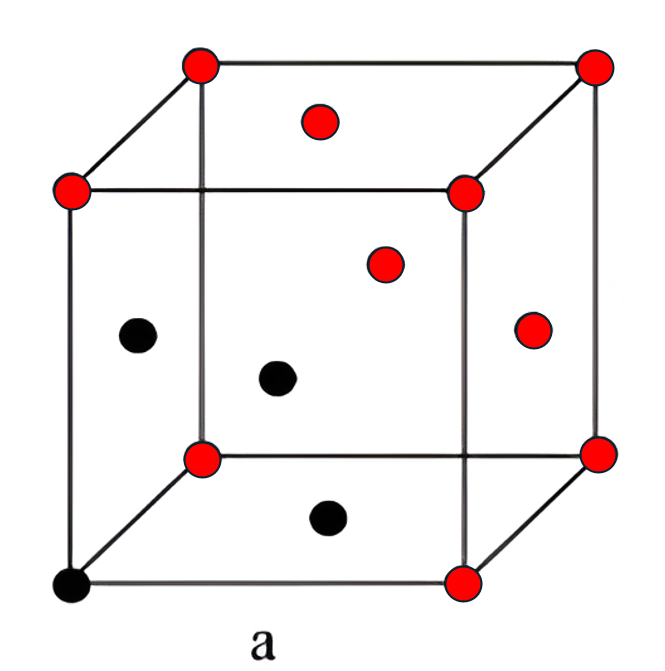
</div>

In the above simple example the red-colored atoms represent all the periodic images of the black-colored atoms. For this reason, if we proceed to place one atom in each position of the lattice and then apply periodic boundary conditions, black and red atoms would coexist at the same spots. Having 2 atoms at the exact same spot (1) breaks the periodicity of the lattice as all atoms must have a distance of at least the lattice constant, and (2) results in infinite Lennard-Jones forces as the atoms at the same spots would have zero relative distances.

A straighforward method to fix this problem is to only take into account the black-colored atoms. While themselves do not create a FCC lattice, applying the periodic boundary conditions spans a full FCC virtual lattice. Speaking from a mathematical point of view, the positions of the black-colored atoms represent the basis of a FCC primitive cell. More specifically,
$$\mathbf{a}_1 = (0, 0, 0)^T \; , \; \mathbf{a}_2 = (a/2, a/2, 0)^T \; , \; \mathbf{a}_3 = (a/2, 0, a/2)^T \; , \; \mathbf{a}_4 = (0, a/2, a/2)^T ,$$
where $a$ is the lattice constant. Therefore, translating this basis in space spans an infinite FCC lattice. Since we deal with a finite-sized box, translating the basis inside the box and then applying periodic boundary conditions is equivalent to spanning an infinite FCC lattice. 


### **Distribution of the initial velocities**

An assumption for the initial velocities of the atoms is that they obey a Maxwell-Boltzmann distribution
$$ f(v_{0 i}) = \sqrt{\frac{m}{2 \pi k_B T}} \exp{\left(- \frac{m v_{0 i}^2}{2 k_B T}\right)} ,$$
where $f (v_{0 i })$ is the probability density of finding a particle with an initial velocity $v_{0 i}$ in the $i$-th direction.

Moreover, we do not want our system to carry any net momentum. For this reason, we explicitly set the average value of the velocities to be zero. In the following cell we demonstrate how the initialization of the velocities obeys the desired distribution by comparing the velocities to the theoretical probability density of the Maxwell-Boltzmann distribution. We can clearly see an agreement between these two for all the components of the velocities.

### **Verifying FCC initialization**

We will showcase that the `init_pos(init_type='fcc')` function correctly implements the initial placements of the atoms into an extented FCC lattice, such that when applies periodic boundary conditions it spans a fully periodic FCC lattice. We will implement the simple case of a unit cell and then extend to more atoms.

The closest number of atoms that can span a virtual periodic FCC lattice is 4. The number of atoms of the corresponding full lattice is 14.
The closest number of atoms that can span a virtual periodic FCC lattice is 108. The number of atoms of the corresponding full lattice is 172.
The closest number of atoms that can span a virtual periodic FCC lattice is 864. The number of atoms of the corresponding full lattice is 1099.


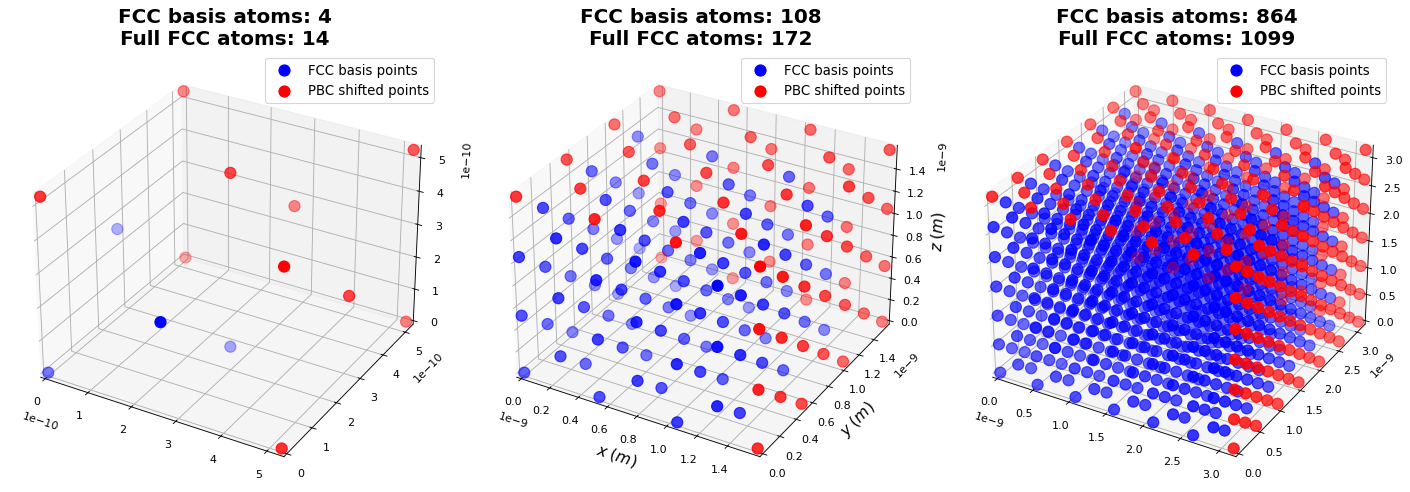

Execution Time: 0.272759 seconds


In [3]:
start_time = time.time() 

# Define different numbers of atoms to test
N_values = [10, 100, 1000]  # Example values

# Create a figure with 3 subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': '3d'})

# Loop over different numbers of atoms and plot on separate subplots
for i, N in enumerate(N_values):
    # Choose parameters
    size = None # Size of the system
    temp = 45  # Temperature (K)
    dim = 3  # Dimensionality of system
    Dt = 1e-3  # Timestep size
    tsteps = 1000  # Total timesteps

    # Initialize molecular motion simulation
    amd1 = molecular_motion(m, N, size, dim, r, temp, Dt, tsteps)

    amd1.size = amd1.periodic_fcc_atoms(amd1.N)[0] * a

    # Get initial positions
    init_pos = amd1.init_positions(init_type='fcc') * sigma  # Shape: (N, 3)

    # Generate Cartesian product for shifts
    shifts = np.array(list(product([0, amd1.size], repeat=3)))  # Shape: (8, 3)
    shifts = shifts[np.any(shifts != 0, axis=1)]  # Remove (0, 0, 0) shift

    # Apply all shifts efficiently using broadcasting
    shifted_positions = init_pos[:, np.newaxis, :] + shifts  # Shape: (N, 7, 3)

    # Reshape into a 2D array (combine N and 7 dimensions)
    shifted_positions = shifted_positions.reshape(-1, 3)  # Shape: (N*7, 3)

    # Keep only points within the box
    shifted_positions = shifted_positions[np.all(shifted_positions <= amd1.size, axis=1)]

    # Extract coordinates for plotting
    x1, y1, z1 = init_pos[:, 0], init_pos[:, 1], init_pos[:, 2]
    x2, y2, z2 = shifted_positions[:, 0], shifted_positions[:, 1], shifted_positions[:, 2]

    # Plot on the corresponding subplot
    ax = axes[i]
    ax.scatter(x1, y1, z1, marker='o', c='b', s=100, label='FCC basis points')
    ax.scatter(x2, y2, z2, marker='o', c='r', s=100, label='PBC shifted points')

    ax.set_xlim(0, amd1.size)
    ax.set_ylim(0, amd1.size)
    ax.set_zlim(0, amd1.size)

    ax.set_title(f"FCC basis atoms: {amd1.N}\nFull FCC atoms: {amd1.periodic_fcc_atoms(amd1.N)[2]}", fontsize=18, fontweight='bold')
    ax.legend(fontsize=12)

axes[1].set_xlabel('$x \\; (m)$', fontsize=14)
axes[1].set_ylabel('$y \\; (m)$', fontsize=14)
axes[1].set_zlabel('$z \\; (m)$', fontsize=14)

plt.tight_layout()
plt.show()

end_time = time.time() 

elapsed_time = end_time - start_time 
print(f"Execution Time: {elapsed_time:.6f} seconds")

### **Verifying the distribution of the initial velocities**

We will showcase that the `init_velocities()` correctly implements a Boltzmann distribution of the initial velocities by comparing the distribution of the initial velocities with the corresponding theoretical probability density of the Boltzmann distribution. We choose a large number of atoms so as to showcase that the histogram converges to the Boltzmann distribution. 

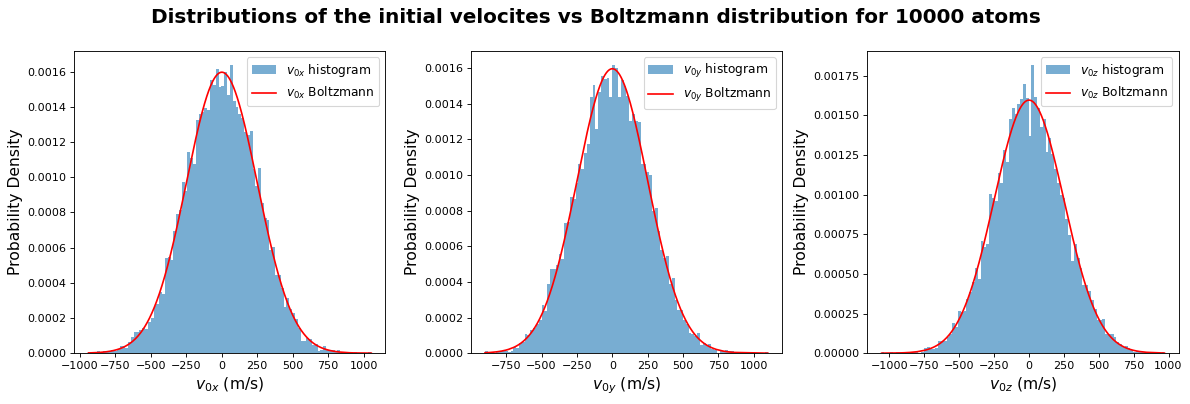

Execution Time: 0.318429 seconds


In [4]:
start_time = time.time() 

# Choose parameters

N = 10000 # Number of atoms
size = None # Size of the system
temp = 300  # Temperature (K)
dim = 3  # Dimensionality of system
Dt = 1e-3  # Timestep size
tsteps = 1000  # Total timesteps

amd2 = molecular_motion(m, N, size, dim, r, temp, Dt, tsteps)
init_vel = amd2.init_velocities() * np.sqrt(amd2.epsilon / m)

v0x, v0y, v0z = init_vel[:, 0], init_vel[:, 1], init_vel[:, 2]

# Boltzmann distribution for each velocity component
v0x_boltz = np.sqrt(m / (2 * np.pi * k_B * amd2.temp)) * np.exp(- (m * np.sort(v0x)**2) / (2 * k_B * amd2.temp))
v0y_boltz = np.sqrt(m / (2 * np.pi * k_B * amd2.temp)) * np.exp(- (m * np.sort(v0y)**2) / (2 * k_B * amd2.temp))
v0z_boltz = np.sqrt(m / (2 * np.pi * k_B * amd2.temp)) * np.exp(- (m * np.sort(v0z)**2) / (2 * k_B * amd2.temp))

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle(f'Distributions of the initial velocites vs Boltzmann distribution for {amd2.N} atoms', fontsize=18, fontweight='bold', y=1.0)

# Number of bins for the histograms
bins = 100

# Plot histograms and Boltzmann distributions
for i, (v, v_boltz, label) in enumerate(zip([v0x, v0y, v0z], [v0x_boltz, v0y_boltz, v0z_boltz], ['$v_{0x}$', '$v_{0y}$', '$v_{0z}$'])):
    # Histogram of velocities
    counts, bin_edges = np.histogram(v, bins=bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    axes[i].hist(v, bins=bins, density=True, alpha=0.6, label=f'{label} histogram')
    
    # Boltzmann distribution
    axes[i].plot(np.sort(v), v_boltz, 'r-', label=f'{label} Boltzmann')
    
    axes[i].set_xlabel(f'{label} (m/s)', fontsize=14)
    axes[i].set_ylabel('Probability Density', fontsize=14)
    axes[i].legend(fontsize=11)

plt.tight_layout()
plt.show()

end_time = time.time() 

elapsed_time = end_time - start_time 
print(f"Execution Time: {elapsed_time:.6f} seconds")

## **Compare the Euler and Velocity-Verlet methods**

In [5]:
start_time = time.time() 

# Choose parameters:

N = 256 # Number of atoms
size = None # Size of the system
temp = 40  # Temperature (K)
dim = 3  # Dimensionality of system
Dt = 1e-3  # Timestep size
tsteps = 10000  # Total timesteps

amd3 = molecular_motion(m, N, size, dim, r, temp, Dt, tsteps)

# Set size to be a multiple of the lattice constant of the corresponding lattice:
amd3.size = amd3.periodic_fcc_atoms(amd3.N)[0] * a

end_time = time.time() 

elapsed_time = end_time - start_time 
print(f"Execution Time: {elapsed_time:.6f} seconds")

Execution Time: 0.000107 seconds


In [6]:
start_time = time.time() 

# Initialization:
init_pos = amd3.init_positions(init_type='fcc')
init_vel = amd3.init_velocities()

end_time = time.time() 

elapsed_time = end_time - start_time 
print(f"Execution Time: {elapsed_time:.6f} seconds")

The closest number of atoms that can span a virtual periodic FCC lattice is 256. The number of atoms of the corresponding full lattice is 365.
Execution Time: 0.000403 seconds


In [7]:
start_time = time.time() 

pos1, vel1, rel_pos1, rel_dist1, energy_values1 = amd3.time_evol(init_pos, init_vel, method='euler', units='on')
kinetic_energies1, potential_energies1, total_energies1 = energy_values1[:, 0], energy_values1[:, 1], energy_values1[:, 2]

end_time = time.time() 

elapsed_time = end_time - start_time 
print(f"Execution Time: {elapsed_time:.6f} seconds")

Time Evolution (Euler): 100%|██████████| 9999/9999 [00:49<00:00, 203.99it/s]


Execution Time: 139.360631 seconds


In [8]:
start_time = time.time() 

pos2, vel2, rel_pos2, rel_dist2, energy_values2 = amd3.time_evol(init_pos, init_vel, method='verlet', units='on')
kinetic_energies2, potential_energies2, total_energies2 = energy_values2[:, 0], energy_values2[:, 1], energy_values2[:, 2]

end_time = time.time() 

elapsed_time = end_time - start_time 
print(f"Execution Time: {elapsed_time:.6f} seconds")

Time Evolution (Verlet): 100%|██████████| 9999/9999 [00:53<00:00, 186.77it/s]


Execution Time: 157.719821 seconds


## **Visualizing the Results**
Below, we animate the atomic motions and plot the system's kinetic/potential/total energies over time for both Euler/Velocity-Verlet methods.

In [9]:
start_time = time.time() 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': '3d'})
fig.suptitle(f'Comparison of Two 3D Systems of {amd3.N} Argon Atoms at $T={amd3.temp}$ K\n(Simulation Time Step $\\Delta t =${Dt})', fontsize=18, fontweight='bold', y=1.0)

fig_size = (10, 8)  # Figure size in inches (width, height)
dpi = 72  # Dots per inch (default for matplotlib)

ax1.set_xlim(0, amd3.size)
ax1.set_ylim(0, amd3.size)
ax1.set_zlim(0, amd3.size)
ax1.set_xlabel('$x \\; (m)$', fontsize=14)
ax1.set_ylabel('$y \\; (m)$', fontsize=14)
ax1.set_zlabel('$z \\; (m)$', fontsize=14)
ax1.set_title(f'Euler method', fontsize=16, fontweight='bold')

ax2.set_xlim(0, amd3.size)
ax2.set_ylim(0, amd3.size)
ax2.set_zlim(0, amd3.size)
ax2.set_xlabel('$x \\; (m)$', fontsize=14)
ax2.set_ylabel('$y \\; (m)$', fontsize=14)
ax2.set_zlabel('$z \\; (m)$', fontsize=14)
ax2.set_title(f'Velocity-Verlet method', fontsize=16, fontweight='bold')

# Calculate the scaling factor
scaling_factor = (2 * r / amd3.size) * fig_size[0] * dpi

# Calculate the marker size (s)
marker_size = scaling_factor ** 2 / 100  # Area of the marker in points squared

# Create an empty scatter plot and update it in-place
scatter1 = ax1.scatter([], [], [], color='purple', s=marker_size)
scatter2 = ax2.scatter([], [], [], color='purple', s=marker_size)

# Animation function
def animate_positions(tstep):
    
    scatter1._offsets3d = (pos1[tstep, :, 0], pos1[tstep, :, 1], pos1[tstep, :, 2])
    scatter2._offsets3d = (pos2[tstep, :, 0], pos2[tstep, :, 1], pos2[tstep, :, 2])
    
    return scatter1, scatter2,

# Animation parameters
fps = 60  # Frames per second
duration = 20  # Animation duration in seconds
total_frames = fps * duration  # Total frames in the animation
interval = 1000 / fps  # Time between frames in milliseconds

# Select a subset of frames from the simulation data
frame_step = int(amd3.tsteps / total_frames)  # Step size to select frames
selected_frames = np.arange(0, amd3.tsteps, frame_step)  # Selected frames for the animation

selected_frames = tqdm(selected_frames, desc="Generating Animation", unit="frames")

# Create the animation
animation = FuncAnimation(
    fig,
    animate_positions,
    frames=selected_frames,  # Use the selected frames
    interval=interval,       # Time between frames in milliseconds
    blit=True                 # Optimize for smooth animation
)
    
plt.close(fig)

# Display the animation
HTML(animation.to_html5_video())


end_time = time.time() 

elapsed_time = end_time - start_time 
print(f"Execution Time: {elapsed_time:.6f} seconds")

Generating Animation: 100%|█████████▉| 1248/1250 [01:04<00:00, 20.36frames/s]

Execution Time: 64.340203 seconds


In [10]:
start_time = time.time() 

# --------------------------- FIGURE SETUP --------------------------- #
fig, ax = plt.subplots(1, 1, figsize=(12, 6), subplot_kw={'projection': '3d'})
fig.suptitle(f'3D System of {amd3.N} Argon Atoms / Virtual FCC Lattice of {amd3.periodic_fcc_atoms(amd3.N)[2]} Argon Atoms at $T=${amd3.temp} K\n(Simulation Time Step $\\Delta t =${Dt})',
             fontsize=16, fontweight='bold', y=1.0)

# Figure settings
fig_size = (10, 8)  # Figure size in inches (width, height)
dpi = 72  # Dots per inch (default for matplotlib)

# --------------------------- AXIS SETTINGS --------------------------- #
ax.set_xlim(0, amd3.size)
ax.set_ylim(0, amd3.size)
ax.set_zlim(0, amd3.size)

# Remove axes and labels
ax.set_xlabel('')  # Remove x-axis label
ax.set_ylabel('')  # Remove y-axis label
ax.set_zlabel('')  # Remove z-axis label

# --------------------------- SET INITIAL VIEW --------------------------- #
initial_elev = 30   # Initial elevation angle
initial_azim = 45   # Initial azimuth angle
final_azim = initial_azim + 360  # One full rotation
ax.view_init(elev=initial_elev, azim=initial_azim)  # Set initial 3D perspective

# --------------------------- SCATTER PLOT SETTINGS --------------------------- #
# Calculate the scaling factor
scaling_factor = (2 * r / amd3.size) * fig_size[0] * dpi
marker_size = scaling_factor ** 2 / 100  # Reduce marker size

# Create an empty scatter plot
scatter = ax.scatter([], [], [], color='purple', s=marker_size)

# --------------------------- ANIMATION PARAMETERS --------------------------- #
fps = 60  # Frames per second
duration = 30  # Total animation duration in seconds
rotation_duration = 30  # Rotation should last exactly 30 seconds (slower rotation)

total_frames = fps * duration  # Total frames in animation
rotation_frames = fps * rotation_duration  # Ensure rotation lasts exactly 30 seconds
interval = 1000 / fps  # Time between frames in milliseconds

# Generate the list of frames with correct spacing
selected_frames = np.linspace(0, amd3.tsteps - 1, total_frames, dtype=int)  # Evenly spaced frames

# --------------------------- ANIMATION FUNCTION --------------------------- #
def animate_positions(frame_idx):
    """ Updates the scatter plot for each frame of the animation """
    
    # Get actual simulation step from selected frames
    tstep = selected_frames[frame_idx]
    
    # Update atom positions
    scatter._offsets3d = (pos2[tstep, :, 0], pos2[tstep, :, 1], pos2[tstep, :, 2])

    # Perform smooth rotation ONLY during the first 30 seconds, then stop
    if frame_idx < rotation_frames:
        progress = frame_idx / rotation_frames  # Normalized progress (0 to 1)
        new_azim = initial_azim + progress * 360  # Smooth rotation
        ax.view_init(elev=initial_elev, azim=new_azim)
    else:
        ax.view_init(elev=initial_elev, azim=final_azim)  # Keep final view fixed

    return scatter,

# --------------------------- PROGRESS BAR --------------------------- #
progress_bar = tqdm(total=len(selected_frames), desc="Generating Animation", unit="frames")

# --------------------------- CREATE ANIMATION --------------------------- #
animation = FuncAnimation(
    fig,
    animate_positions,
    frames=len(selected_frames),  # Now uses the correct frame count
    interval=interval,
    blit=True
)

plt.close(fig)

# --------------------------- DISPLAY ANIMATION --------------------------- #
HTML(animation.to_html5_video())


end_time = time.time() 

elapsed_time = end_time - start_time 
print(f"Execution Time: {elapsed_time:.6f} seconds")

Generating Animation: 100%|█████████▉| 1248/1250 [01:08<00:00, 18.25frames/s]


Execution Time: 40.560994 seconds


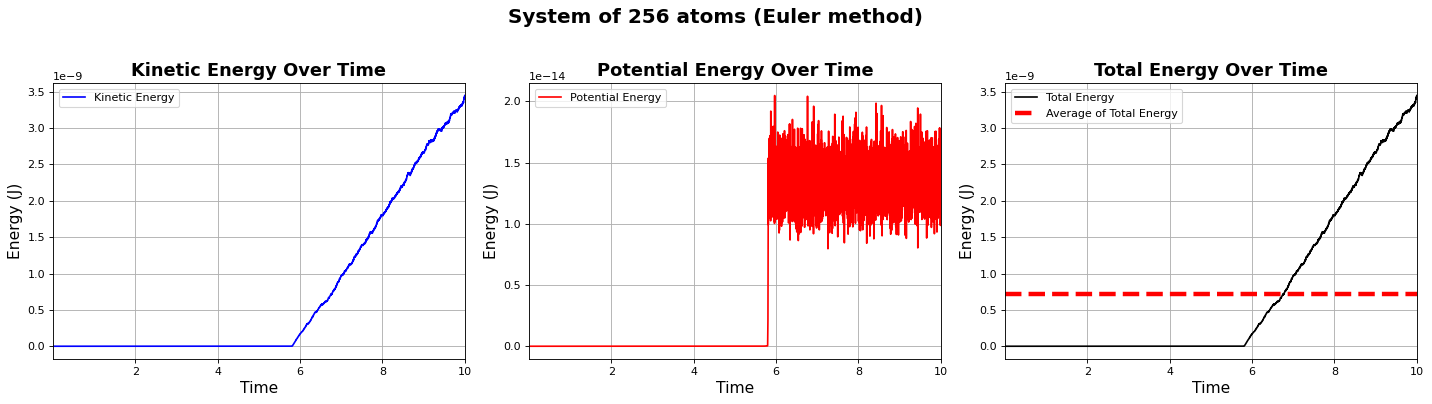

Execution Time: 0.164821 seconds


In [11]:
start_time = time.time() 

time_interval = np.arange(0, amd3.tsteps * Dt, Dt)
avg_energy1 = np.mean(total_energies1)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle(f'System of {amd3.N} atoms (Euler method)', fontsize=18, fontweight='bold', y=1.0)

# Kinetic energy
axes[0].plot(time_interval, kinetic_energies1, label="Kinetic Energy", color='blue')
axes[0].set_xlim(Dt, amd3.tsteps * Dt)
axes[0].set_xlabel("Time", fontsize=14)
axes[0].set_ylabel("Energy (J)", fontsize=14)
axes[0].set_title("Kinetic Energy Over Time", fontsize=16, fontweight='bold')
axes[0].legend()
axes[0].grid()

# Potential energy
axes[1].plot(time_interval, potential_energies1, label="Potential Energy", color='red')
axes[1].set_xlim(Dt, amd3.tsteps * Dt)
axes[1].set_xlabel("Time", fontsize=14)
axes[1].set_ylabel("Energy (J)", fontsize=14)
axes[1].set_title("Potential Energy Over Time", fontsize=16, fontweight='bold')
axes[1].legend()
axes[1].grid()

# Total energy
axes[2].plot(time_interval, total_energies1, label="Total Energy", color='black')
axes[2].axhline(y=avg_energy1, color='r', linestyle='--', linewidth=4, label='Average of Total Energy')
axes[2].set_xlim(Dt, amd3.tsteps * Dt)
axes[2].set_xlabel("Time", fontsize=14)
axes[2].set_ylabel("Energy (J)", fontsize=14)
axes[2].set_title("Total Energy Over Time", fontsize=16, fontweight='bold')
axes[2].legend()
axes[2].grid()

plt.tight_layout()
plt.show()


end_time = time.time() 

elapsed_time = end_time - start_time 
print(f"Execution Time: {elapsed_time:.6f} seconds")

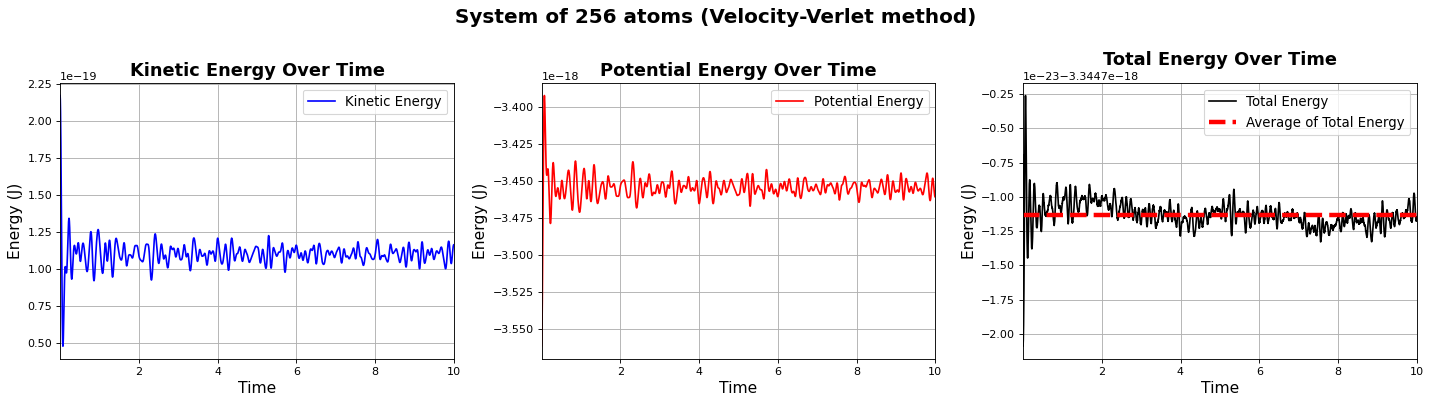

Execution Time: 0.164040 seconds


In [12]:
start_time = time.time() 

avg_energy2 = np.mean(total_energies2)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle(f'System of {amd3.N} atoms (Velocity-Verlet method)', fontsize=18, fontweight='bold', y=1.0)

# Kinetic energy
axes[0].plot(time_interval, kinetic_energies2, label="Kinetic Energy", color='blue')
axes[0].set_xlim(Dt, amd3.tsteps * Dt)
axes[0].set_xlabel("Time", fontsize=14) 
axes[0].set_ylabel("Energy (J)", fontsize=14) 
axes[0].set_title("Kinetic Energy Over Time", fontsize=16, fontweight='bold')
axes[0].legend(fontsize=12)
axes[0].grid()

# Potential energy
axes[1].plot(time_interval, potential_energies2, label="Potential Energy", color='red')
axes[1].set_xlim(Dt, amd3.tsteps * Dt)
axes[1].set_xlabel("Time", fontsize=14) 
axes[1].set_ylabel("Energy (J)", fontsize=14)  
axes[1].set_title("Potential Energy Over Time", fontsize=16, fontweight='bold')
axes[1].legend(fontsize=12)
axes[1].grid()

# Total energy
axes[2].plot(time_interval, total_energies2, label="Total Energy", color='black')
axes[2].axhline(y=avg_energy2, color='r', linestyle='--', linewidth=4, label='Average of Total Energy')
axes[2].set_xlim(Dt, amd3.tsteps * Dt)
axes[2].set_xlabel("Time", fontsize=14) 
axes[2].set_ylabel("Energy (J)", fontsize=14)  
axes[2].set_title("Total Energy Over Time", fontsize=16, fontweight='bold')
axes[2].legend(fontsize=12)
axes[2].grid()

plt.tight_layout()
plt.show()

end_time = time.time() 

elapsed_time = end_time - start_time 
print(f"Execution Time: {elapsed_time:.6f} seconds")

## **Results and Analysis**

### **Particle Motion and Collisions**

**Euler method**
- In the atomic scale, we clearly observe an unphysical behaviour of the system due to the method's instability. The velocities quickly begin to uncontrollably grow which is translated into an "exploding-velocities" behaviour.

**Velocity-Verlet method**
- We observe very interesting dynamics in the atomic scale. The complex motion of each atom is a result of feeling the attrative and repulsive parts of the Lennard-Jones potential from all the surrounding atoms. We do not observe an unphysical behaviour. Contrary to the Euler method, the Velocity-Verlet method maintains a stable behaviour.

### **Energy Conservation**

**Euler method**
- The potential energy fluctuate as expected due to particle interactions, but the kinetic energy continuously grows, which matches the "exploding-velocities" behaviour of the method (see first row of plots above).
- The total energy of the system is not conserved, as we would expect for this numerical method, indicating the unsuitability of the Euler method for this class of dynamical systems.

**Velocity-Verlet method**
- Kinetic and potential energy fluctuate as expected due to particle interactions (see second row of plots above).
- The total energy is now conserved on average, as we can clearly see. The small number of fluctuations appearing is expected since we do not solve the system of equations of motion analytically. However, these fluctuations are magnitudes of order smaller than the average total_energy, which remains constant in time, indicating the suitability of the Velocity-Verlet method for this class of dynamical systems.

## **Temperature of the system and rescaling of velocities**

While we initially set the velocities to obey a Boltzmann distribution associated with a temperature $T_0$, this does not imply that the system will be at the same temperature. In the initialization step of the system, the particles have only kinetic energies due to the velocities since before the first step of the time evolution of the system the Lennard-Jones interactions are not taken into account. Therefore, as soon as the time evolution begins, there will be an exchange between the kinetic and potential energies of the system until the system finally equilibrates at some temperature $T_1$. This temperature is connected to the kinetic energy of the system in equilibrim by the equipartition theorem, via the relation $E_{kin} = \frac{3}{2} (N - 1) k_B T_1$, where $N$ is the number of particles in the system. The term $N-1$ arises because the system is closed, meaning that the total momentum is conserved. That is,
$$\sum_{i \neq j} \mathbf{F}_{ij} = m \frac{d}{dt} \sum_{i} \mathbf{v}_{i} = \mathbf{0} ,$$
where this equation essentially removes one degree of freedom from the system of $N$ particles.

Because some part of the initial kinetic energy converts to potential energy, we should expect that the equilibrium kinetic energy will be different than the initial kinetic energy, implying that $T_1 \neq T_0$. If we want to force our system to equilibrate at the initial temperature $T_0$, we must apply an iterative process in which we let the system equilibrate, then perform a rescaling $\mathbf{v}_i \rightarrow \lambda \mathbf{v}_i$, let the system equilibrate again, and repeat as many time as needed. Essentially, the final system in equilibrium will be at the desired temperature. After rescaling and waiting till the system equilibrates, we want the temperature of the system to be $T_0$ and therefore, the kinetic energy to be
$$ \frac{1}{2} m \lambda^2 \sum_{i} \mathbf{v}_i^2 = \frac{3}{2} (N - 1) k_B T_0 \Rightarrow \lambda = \sqrt{\frac{3 (N - 1) k_B T_0}{\sum_{i} m \mathbf{v}_i^2}} .$$
Assuming that $E_{kin}^{(k)}$ is the kinetic energy in the $k$-th iteration of rescaling and equilibration, we distinguish the following cases:
- If $E_{kin}^{(k)} = \frac{1}{2} m \sum_{i} (\mathbf{v}_i^{(k)})^2 < \frac{3}{2} (N - 1) k_B T_0 \Rightarrow \lambda^{(k)} > 1 \Rightarrow E_{kin}^{(k+1)} = \frac{1}{2} m \sum_{i} (\mathbf{v}_i^{(k+1)})^2 = \frac{1}{2} m \sum_{i} (\lambda^{(k)} \mathbf{v}_i^{(k)})^2 > \frac{1}{2} m \sum_{i} (\mathbf{v}_i^{(k)})^2 \Rightarrow \lambda^{(k+1)} < \lambda^{(k)}$.
  
-  If $E_{kin}^{(k)} = \frac{1}{2} m \sum_{i} (\mathbf{v}_i^{(k)})^2 > \frac{3}{2} (N - 1) k_B T_0 \Rightarrow \lambda^{(k)} < 1 \Rightarrow E_{kin}^{(k+1)} = \frac{1}{2} m \sum_{i} (\mathbf{v}_i^{(k+1)})^2 = \frac{1}{2} m \sum_{i} (\lambda^{(k)} \mathbf{v}_i^{(k)})^2 <\frac{1}{2} m \sum_{i} (\mathbf{v}_i^{(k)})^2 \Rightarrow \lambda^{(k+1)} > \lambda^{(k)}$.

In both cases we see that by constantly rescaling and equilibrating we approach the value $\lambda = 1$, which implies that $E_{kin} = \frac{3}{2} (N - 1) k_B T_0$, meaning that the temperature of the system in equilibrium approaches the temperature $T_0$ corresponding to the first initialization of velocities.

### **Observables, expectation values**

When we reach the desired temperature after $n_0$ timesteps, we can proceed to calculate expectation values of observables. Before doing that, we should mention that each iteration of rescaling, produces a completely new microscopic configuration of the system. In statistical mechanics, the expectation value of an observable $A$ is simply the average that observable over all possible statistical configurations of the system. Since our case of interest is to study the system in equilibrium and at the desired temperature, the statistical averages of observables are calculated as
$$\braket{A} = \lim_{n \rightarrow \infty} \frac{1}{n - n_0} \sum_{\nu > n_0}^{n} A_{\nu} ,$$
where $A_{\nu}$ is the value of the observable at the configuration corresponding to the times step $\nu$.


### **Pair-correlation function**

As we vary the temperature and the pressure of the system we might encounter phase transitions, i.e. moving from one phase of the system to another. Each phase is characterized by a degree of order. Solids will have the highest order as atoms are placed in a lattice (crystal or amorphous), and as we move to the liquid and gas phases the degree of order keeps decreasing, as we introduce more and more homogenuity in the system by relaxing the bonding between neighboring atoms. An important measure of this order is the pair-correlation, or radial distribution, function $g (r)$, which gives the probability of finding a particle in a given distance $r$ away from a reference particle, relative to an ideal gas, where positions of particles are uncorrelated. A formula for the pair-correlation function is
$$g(r) = \frac{2 V}{N (N - 1)} \frac{\braket{n (r)}}{4 \pi r^2 \Delta r} ,$$
where $V$ is the volume of the system, $N$ is the number of particles, $n (r)$ is a histogram of the particle pais within a distance $[r, r + \Delta r]$, with $\Delta r$ being bin size of the histogram. As we will see, depending on the phase of the system this function takes different forms, revealing the change in order of the system.

### **Pressure**

To calculate the pressure of a system of particles we make use of the Virial theorem, according to which the pressure can be calculated as
$$\frac{\beta P}{n} = 1 - \frac{\beta}{3 N} \left<\frac{1}{2} \sum_{i, j} r_{i j} \frac{\partial U}{\partial r_{ij}}\right> ,$$
where $\beta = (k_B T)^{-1}$, $N$ is the particle number, $n$ is the particle density, $U$ is the potential energy for a pair of particles, and $r_{ij}$ are the distances between pairs of particles. We notice here that if the average value on the right vanishes (e.g. there is no potential), we simply retrieve the ideal gas law $P = n k_B T$. As we compute the pressure for different temperatures we will some times notice very large deviations for the ideal gas pressure, signifying that we might be in a different phase. We might also encounter the strange result of negative pressures!

### **Specific Heat**

To calculate the specific heat per particle of the system, we use the Lebowitz formula which takes into account the fluctuations of the kinetic energy of the system:
$$ \frac{\left< \delta E_{kin}^2 \right>}{\left< E_{kin} \right>^2} = \frac{2}{3 N} \left( 1 - \frac{3}{2 c_V} \right) ,$$
where $\left< \delta E_{kin}^2 \right> = \left<E_{kin}^2 \right> - \left< E_{kin} \right>^2$ is the variance of the kinetic energy, and $c_V$ is the specific heat per particle.

### **Diffusion coefficient**

A concept that arises naturally when we study the dynamics of systems of particles, is that of diffusion. Roughly speaking, diffusion is the tendency of a particle distribution to even out as time passes. That is a direct consequence of Fick's law,
$$ \mathbf{J}_{diff} (\mathbf{r}, t) = - \nabla \rho (\mathbf{r}, t) ,$$
where $\rho (\mathbf{r}, t)$ is the probability density of finding a particle at a position $\mathbf{r}$ at time $t$. $\mathbf{J}_{diff}$ is the diffusion current and as we see it has a direction opposite to the gradient of the probability density. That is, the more crowded a region is, the more the particles diffuse outside that region. The intuition behind this is essentially having more collisions inside the crowded areas compared to the less crowded areas, and this excess of collisions pushes a net number of particles outside the crowded area, until equilibrium is reached.

To study the diffusive behaviour of a system, we need to look at the average displacements of particles, and more specifically at mean-square discplacement 
$$ \left< \Delta^2 \mathbf{x} (t) \right> = \left< \: [\mathbf{x} (t) - \mathbf{x} (0)]^2 \right> ,$$
where $\mathbf{x} (0)$ is the initial position of a particle. In the regime of very short times, where collisions do not still occur, the particles move balistically in straight lines, meaning that $\mathbf{x} (t) = \mathbf{x} (0) + \mathbf{v} (0) t$, and therefore,
$$\left< \Delta^2 \mathbf{x} (t) \right> = \left< \mathbf{v}^2 (0) \right> t^2 ,$$
where $\mathbf{v}^2 (0) = 3 k_B T / m$ from the equipartition theorem. For longer times, where scattering is occuring, we encounter a relation of the form $\left< \Delta^2 \mathbf{x} (t) \right> \propto t$. This relation translates to having a smaller average displacement over time, compared to the ballistic behaviour, which makes sense considering that the particles constantly scatter. This proportionality between $\left< \Delta^2 \mathbf{x} (t) \right>$ and $t$ is connected via a characteristic coefficient $D$ called the diffusion coefficient. We can estimate this coefficient by the Einstein relation
$$ D = \lim_{t \rightarrow \infty} \frac{1}{6 t} \left< \Delta^2 \mathbf{x} (t) \right> .$$
In the cases of a gas or a liquid, we should obtain a non-zero diffusion coefficient. However, in the case of solids, the atoms vibrate around their lattice positions. While there are many different vibrational modes and non-trivial vibrational motions, the displacement reaches a plateau corresponding to the characteristic vibrational frequency of the solid. Since the diffusion coefficient relates the scaling of the mean-square displacement with time, it means that for solid we should obtain an approximately zero diffusion coefficient, since we no longer have a scaling.

## **Error Analysis on Observables**

### **Autocorrelation Function**

In a molecular dynamics simulation, the data sequence retains a memory of previous configurations, meaning that subsequent values of an observable are not entirely independent. This is quantified using the autocorrelation function. Given a time series of an observable $A_n$, we define the normalized autocorrelation function as

$$
\chi_A(t) = \frac{1}{\text{Var}(A)} \sum_n (A_n - \langle A \rangle) (A_{n+t} - \langle A \rangle) ,
$$

which measures the correlation of fluctuations at a given lag time $t$. This assumes that the system is in a stationary process.

#### **Lag Time vs. Simulation Time Step**
- The variable $t$ in $\chi_A(t)$ represents the lag time, which is the separation between two points in the dataset when computing the autocorrelation function.
- It does not correspond to the simulation time step $\Delta t$.
- The correlation time $\tau$ is estimated from the decay of $\chi_A(t)$, typically following an exponential decay

$$
\chi_A(t) \approx e^{-t/\tau} .
$$

To obtain statistically independent samples, we must wait at least one correlation time $\tau$ before taking measurements.

#### **Estimating Errors Using Autocorrelation**
The error in our simulation result is given by:

$$
\sigma_A = \sqrt{\frac{2\tau}{N} \left( \langle A^2 \rangle - \langle A \rangle^2 \right)}
$$

which accounts for the correlation time $\tau$ and the number of data points $N$.

#### **Computing Autocorrelation from Finite Data**
For a finite-length simulation, the autocorrelation function can be computed using:

$$
\chi_A(t) = \frac{(N - t) \sum_n A_n A_{n+t} - \sum_n A_n \sum_n A_{n+t}}{\sqrt{(N - t) \sum_n A_n^2 - \left( \sum_n A_n \right)^2} \sqrt{(N - t) \sum_n A_{n+t}^2 - \left( \sum_n A_{n+t} \right)^2}}
$$

where $1 \leq n \leq N - t$. To extract $\tau$, one would fit $\chi_A(t)$ to an exponential decay $e^{-t/\tau}$. The choice of $t$ affects accuracy — if too small, it may not capture $\tau$, while if too large, may introduce noise due to fewer contributing data points.

### **Velocity rescaling**

In the following cell we implement the rescaling process. After we reach the desired temperature we keep iterating in order to verify that indeed the system converges to that temperature by plotting the results.

In [4]:
start_time = time.time() 

# Choose parameters:

N = 108  # Number of atoms
mol = N / N_A  # Number of moles
m_density = np.array([41.320, 35.298, 2.0591])  # Molar density (mol/L)
temps = np.array([40, 85, 300])  # Temperatures (K)
V_dm = mol / m_density  # Volume in L
V_m = V_dm * 1e-3  # Volume in m³
n_density = N / V_m # Number density (atoms/m³) 
sizes = V_m**(1/3)  # System size in m
Dt = 1e-3  # Timestep size
tsteps = 2000  # Total timesteps
iterations = 20

pos_all = np.empty((len(temps), N, dim))
vel_all = np.empty((len(temps), N, dim))
energies_all = np.empty((len(temps), iterations * tsteps, 3))

for i, (temp, size) in enumerate(zip(temps, sizes)):

    amd4 = molecular_motion(m, N, size, dim, r, temp, Dt, tsteps)

    init_pos = amd4.init_positions(init_type='fcc')
    init_vel = amd4.init_velocities()

    avg_energies = np.empty((iterations, 3))
    equilibrium_start = None
    equilibrium_count = 0

    for it in range(iterations):
        
        pos, vel, rel_pos, rel_dist, energy_values = amd4.time_evol(init_pos, init_vel, method='verlet', units='off')

        # Store energies with correct conversion:
        energies_all[i, it * tsteps : (it + 1) * tsteps] = energy_values * amd4.epsilon

        # Compute average kinetic, potential, and total energy:
        avg_energies[it] = np.mean(energy_values, axis=0)
        avg_kin_en, avg_pot_en, avg_en = avg_energies[it]

        if equilibrium_start is not None:
            equilibrium_count += 1
            
        elif it > 0 and abs(avg_kin_en - avg_energies[it - 1, 0]) < 0.01 * abs(avg_kin_en):
            equilibrium_start = it
            equilibrium_count = 1

        rescale = np.sqrt(((amd4.N - 1) * 3 * k_B * amd4.temp) / (2 * amd4.epsilon * avg_kin_en))
        init_pos = pos[-1]
        init_vel = vel[-1] * rescale  # Apply rescaling

    equilibrium_message = (
        f"Temperature (T={amd4.temp} K) reached at iteration {equilibrium_start}, counted for {equilibrium_count} iterations."
        if equilibrium_start is not None else "Equilibrium was not reached within the given iterations."
    )

    pos_all[i], vel_all[i] = pos[-1], vel[-1]

    print(equilibrium_message)

print('End of rescaling process.')


end_time = time.time() 

elapsed_time = end_time - start_time 
print(f"Execution Time: {elapsed_time:.6f} seconds")

The closest number of atoms that can span a virtual periodic FCC lattice is 108. The number of atoms of the corresponding full lattice is 172.


Time Evolution (Verlet): 100%|██████████| 1999/1999 [00:01<00:00, 1119.14it/s]


Temperature (T=40 K) reached at iteration 5, counted for 15 iterations.
The closest number of atoms that can span a virtual periodic FCC lattice is 108. The number of atoms of the corresponding full lattice is 172.


Time Evolution (Verlet): 100%|██████████| 1999/1999 [00:01<00:00, 1115.52it/s]


Temperature (T=85 K) reached at iteration 10, counted for 10 iterations.
The closest number of atoms that can span a virtual periodic FCC lattice is 108. The number of atoms of the corresponding full lattice is 172.


Time Evolution (Verlet): 100%|██████████| 1999/1999 [00:01<00:00, 1055.60it/s]

Temperature (T=300 K) reached at iteration 1, counted for 19 iterations.
End of rescaling process.
Execution Time: 109.481063 seconds


### **Visualization of the rescaling process**

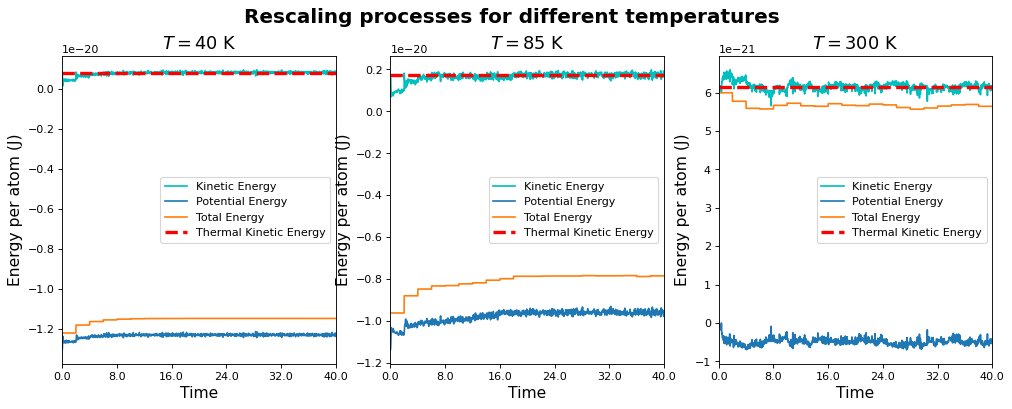

Execution Time: 0.491921 seconds


In [5]:
start_time = time.time() 

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Rescaling processes for different temperatures', fontsize=18, fontweight='bold', y=1.0)

total_tsteps = iterations * tsteps
its = np.arange(0, total_tsteps)
E_thermal = (3/2) * ((amd4.N - 1) / amd4.N) * k_B * temps 

for i, temp in enumerate(temps):
   
    kin_en = ax[i].plot(its, energies_all[i, :, 0] / amd4.N, color='c', label='Kinetic Energy')
    pot_en = ax[i].plot(its, energies_all[i, :, 1] / amd4.N, label='Potential Energy')
    total_en = ax[i].plot(its, energies_all[i, :, 2] / amd4.N, label='Total Energy')
    ax[i].axhline(y=E_thermal[i], color='r', linestyle='--', linewidth=3, label='Thermal Kinetic Energy')
    
    ax[i].set_title(f'$T={temp}$ K', fontsize=16)
    ax[i].set_xlabel('Time', fontsize=14)
    ax[i].set_ylabel('Energy per atom (J)', fontsize=14)
    ax[i].set_xlim(0, its[-1])
    ax[i].set_xticks(np.linspace(0, total_tsteps, 6))  
    ax[i].set_xticklabels(np.linspace(0, total_tsteps, 6)*amd4.Dt)  
    ax[i].legend()

plt.show()

end_time = time.time() 

elapsed_time = end_time - start_time 
print(f"Execution Time: {elapsed_time:.6f} seconds")

In [6]:
start_time = time.time() 

# Choose parameters:

N = amd4.N
tsteps = 15000
pos_eq, vel_eq = np.empty((len(temps), tsteps, N, dim)), np.empty((len(temps), tsteps, N, dim))
rel_pos_eq, rel_dist_eq = np.empty((len(temps), tsteps, N, N, dim)), np.empty((len(temps), tsteps, N, N))
energies_eq = np.empty((len(temps), tsteps, 3))

for i, (temp, size) in enumerate(zip(temps, sizes)):
    
    amd5 = molecular_motion(m, N, sizes[i], dim, r, temp, Dt, tsteps)
    init_pos, init_vel = pos_all[i], vel_all[i]
    pos_eq[i], vel_eq[i], rel_pos_eq[i], rel_dist_eq[i], energies_eq[i] = amd5.time_evol(init_pos, init_vel, method='verlet', units='off')

end_time = time.time() 

elapsed_time = end_time - start_time 
print(f"Execution Time: {elapsed_time:.6f} seconds")

Time Evolution (Verlet): 100%|██████████| 14999/14999 [00:14<00:00, 1019.69it/s]


Execution Time: 50.005222 seconds


### **Calculation and plotting of the radial distribution function $g (r)$**

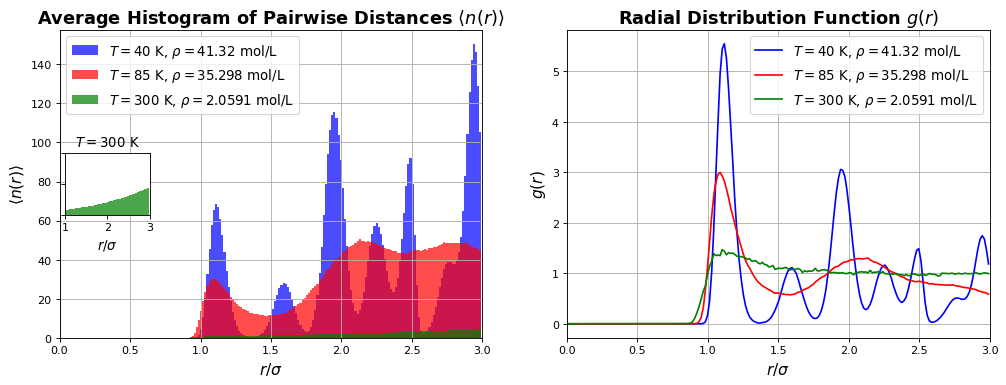

Execution Time: 7.832842 seconds


In [7]:
start_time = time.time() 

fig, ax = plt.subplots(1, 2, figsize=(15,5))

colors = ['b', 'r', 'g']
hist_legend_labels = []  
rdf_legend_labels = []  

for i, (temp, rho, color) in enumerate(zip(temps, m_density, colors)):

    # Initialize an array to store histograms for all timesteps:
    hist_values_all = []
    
    # Loop over each timestep and compute the histograms:
    for t in range(amd5.tsteps):
        # Extract the upper triangular part, excluding the diagonal (k=1)
        n_r = np.triu(rel_dist_eq[i, t], k=1)
        
        # Flatten the matrix and remove zero values
        n_r = n_r[n_r != 0]  # Keep only non-zero values
        
        # Compute histogram for the current timestep
        hist_range = (0, 3)
        hist_values, bin_edges = np.histogram(n_r, bins=200, range=hist_range)
        
        # Append histogram values for the current timestep
        hist_values_all.append(hist_values)
    
    # Stack histograms into a 2D array (timesteps x histogram bins):
    hist_values_all = np.array(hist_values_all)
    
    # Take the average histogram over all timesteps:
    avg_n_r = np.mean(hist_values_all, axis=0)

    # Average histogram of pairwise distances:
    ax[0].bar(bin_edges[:-1], avg_n_r, width=np.diff(bin_edges), alpha=0.7, color=color)
    hist_legend_labels.append(f'$T={temp}$ K, $\\rho={rho}$ mol/L')  
    
    # Radial distribution function calculation:
    r_dist = (bin_edges[:-1] + bin_edges[1:]) / 2  # Midpoints of the bins
    V = ((sizes[i] / amd5.sigma)**3) 
    Δr = bin_edges[1] - bin_edges[0]  
    g_r = ((2 * V) / (amd5.N * (amd5.N - 1))) * (avg_n_r / (4 * np.pi * r_dist**2 * Δr))  # g(r) calculation
    
    # Plot radial distribution function:
    ax[1].plot(r_dist, g_r, color=color)
    rdf_legend_labels.append(f'$T={temp}$ K, $\\rho={rho}$ mol/L')  
    

ax_zoom = inset_axes(ax[0], width="20%", height="20%", loc='center left')  # Adjust position & size
ax_zoom.bar(bin_edges[:-1], avg_n_r, width=np.diff(bin_edges), alpha=0.7, color='g')
ax_zoom.set_xlim(1, 3)  
ax_zoom.set_ylim(0, 10) 
ax_zoom.set_yticklabels([])
ax_zoom.set_title('$T=300$ K')
ax_zoom.set_xlabel('$r / \\sigma$', fontsize=12)

ax[0].set_xlim(0, 3)
ax[0].set_title("Average Histogram of Pairwise Distances $\\left<n(r)\\right>$", fontsize=16, fontweight='bold')
ax[0].set_xlabel("$r / \\sigma$", fontsize=14)
ax[0].set_ylabel("$\\left<n(r)\\right>$", fontsize=14)
ax[0].legend(hist_legend_labels, fontsize=12)  
ax[0].grid()

ax[1].set_xlim(0, 3)
ax[1].set_title("Radial Distribution Function $g(r)$", fontsize=16, fontweight='bold')
ax[1].set_xlabel("$r / \\sigma$", fontsize=14)
ax[1].set_ylabel("$g(r)$", fontsize=14)
ax[1].legend(rdf_legend_labels, fontsize=12)  
ax[1].grid()

plt.show()

end_time = time.time() 

elapsed_time = end_time - start_time 
print(f"Execution Time: {elapsed_time:.6f} seconds")

### **Calculation of pressure**

Here we repeat the rescaling process but this time for different pairs of temperatures and densities, since we want to compare the pressures of vapor Ar with literature values.

In [8]:
start_time = time.time() 

# Choose parameters:

N = 32  # Number of atoms
mol = N / N_A  # Number of moles
# Literature values for density and temperature:
m_density = np.array([0.11500, 0.18651, 0.28701, 0.42327, 0.60305, 0.83561, 1.1325, 1.5090, 1.9863, 2.5970, 3.3956, 4.4877, 6.1362, 9.7789])  # Molar density (mol/L)
temps = np.array([85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150])  # Temperatures (K)
V_dm = mol / m_density  # Volume in L
V_m = V_dm * 1e-3  # Volume in m³
n_density = N / V_m # Number density (atoms/m³) 
sizes = V_m**(1/3)  # System size in m
Dt = 1e-3  # Timestep size
tsteps = 2000  # Total timesteps
iterations = 20

pos_all = np.empty((len(temps), N, dim))
vel_all = np.empty((len(temps), N, dim))
energies_all = np.empty((len(temps), iterations * tsteps, 3))

for i, (temp, size) in enumerate(zip(temps, sizes)):

    amd6 = molecular_motion(m, N, size, dim, r, temp, Dt, tsteps)

    init_pos = amd6.init_positions(init_type='fcc')
    init_vel = amd6.init_velocities()

    avg_energies = np.empty((iterations, 3))
    equilibrium_start = None
    equilibrium_count = 0

    for it in range(iterations):
        
        pos, vel, rel_pos, rel_dist, energy_values = amd6.time_evol(init_pos, init_vel, method='verlet', units='off')

        # Store energies with correct conversion:
        energies_all[i, it * tsteps : (it + 1) * tsteps] = energy_values * amd6.epsilon

        # Compute average kinetic, potential, and total energy:
        avg_energies[it] = np.mean(energy_values, axis=0)
        avg_kin_en, avg_pot_en, avg_en = avg_energies[it]

        if equilibrium_start is not None:
            equilibrium_count += 1
            
        elif it > 0 and abs(avg_kin_en - avg_energies[it - 1, 0]) < 0.01 * abs(avg_kin_en):
            equilibrium_start = it
            equilibrium_count = 1

        rescale = np.sqrt(((amd6.N - 1) * 3 * k_B * amd6.temp) / (2 * amd6.epsilon * avg_kin_en))
        init_pos = pos[-1]
        init_vel = vel[-1] * rescale  # Apply rescaling

    equilibrium_message = (
        f"Temperature (T={amd6.temp} K) reached at iteration {equilibrium_start}, counted for {equilibrium_count} iterations."
        if equilibrium_start is not None else "Equilibrium was not reached within the given iterations."
    )

    pos_all[i], vel_all[i] = pos[-1], vel[-1]

    print(equilibrium_message)

end_time = time.time() 

elapsed_time = end_time - start_time 
print(f"Execution Time: {elapsed_time:.6f} seconds")

The closest number of atoms that can span a virtual periodic FCC lattice is 32. The number of atoms of the corresponding full lattice is 63.


Time Evolution (Verlet): 100%|██████████| 1999/1999 [00:00<00:00, 8477.88it/s]


Temperature (T=85 K) reached at iteration 1, counted for 19 iterations.
The closest number of atoms that can span a virtual periodic FCC lattice is 32. The number of atoms of the corresponding full lattice is 63.


Time Evolution (Verlet): 100%|██████████| 1999/1999 [00:00<00:00, 8782.53it/s]


Temperature (T=90 K) reached at iteration 8, counted for 12 iterations.
The closest number of atoms that can span a virtual periodic FCC lattice is 32. The number of atoms of the corresponding full lattice is 63.


Time Evolution (Verlet): 100%|██████████| 1999/1999 [00:00<00:00, 8981.89it/s]


Temperature (T=95 K) reached at iteration 6, counted for 14 iterations.
The closest number of atoms that can span a virtual periodic FCC lattice is 32. The number of atoms of the corresponding full lattice is 63.


Time Evolution (Verlet): 100%|██████████| 1999/1999 [00:00<00:00, 9056.31it/s]


Temperature (T=100 K) reached at iteration 4, counted for 16 iterations.
The closest number of atoms that can span a virtual periodic FCC lattice is 32. The number of atoms of the corresponding full lattice is 63.


Time Evolution (Verlet): 100%|██████████| 1999/1999 [00:00<00:00, 8406.89it/s]


Temperature (T=105 K) reached at iteration 3, counted for 17 iterations.
The closest number of atoms that can span a virtual periodic FCC lattice is 32. The number of atoms of the corresponding full lattice is 63.


Time Evolution (Verlet): 100%|██████████| 1999/1999 [00:00<00:00, 8236.95it/s]


Temperature (T=110 K) reached at iteration 3, counted for 17 iterations.
The closest number of atoms that can span a virtual periodic FCC lattice is 32. The number of atoms of the corresponding full lattice is 63.


Time Evolution (Verlet): 100%|██████████| 1999/1999 [00:00<00:00, 8229.73it/s]


Temperature (T=115 K) reached at iteration 2, counted for 18 iterations.
The closest number of atoms that can span a virtual periodic FCC lattice is 32. The number of atoms of the corresponding full lattice is 63.


Time Evolution (Verlet): 100%|██████████| 1999/1999 [00:00<00:00, 9118.11it/s]


Temperature (T=120 K) reached at iteration 4, counted for 16 iterations.
The closest number of atoms that can span a virtual periodic FCC lattice is 32. The number of atoms of the corresponding full lattice is 63.


Time Evolution (Verlet): 100%|██████████| 1999/1999 [00:00<00:00, 9181.26it/s]


Equilibrium was not reached within the given iterations.
The closest number of atoms that can span a virtual periodic FCC lattice is 32. The number of atoms of the corresponding full lattice is 63.


Time Evolution (Verlet): 100%|██████████| 1999/1999 [00:00<00:00, 9081.58it/s]


Temperature (T=130 K) reached at iteration 3, counted for 17 iterations.
The closest number of atoms that can span a virtual periodic FCC lattice is 32. The number of atoms of the corresponding full lattice is 63.


Time Evolution (Verlet): 100%|██████████| 1999/1999 [00:00<00:00, 9108.51it/s]


Temperature (T=135 K) reached at iteration 5, counted for 15 iterations.
The closest number of atoms that can span a virtual periodic FCC lattice is 32. The number of atoms of the corresponding full lattice is 63.


Time Evolution (Verlet): 100%|██████████| 1999/1999 [00:00<00:00, 9114.61it/s]


Temperature (T=140 K) reached at iteration 8, counted for 12 iterations.
The closest number of atoms that can span a virtual periodic FCC lattice is 32. The number of atoms of the corresponding full lattice is 63.


Time Evolution (Verlet): 100%|██████████| 1999/1999 [00:00<00:00, 9086.23it/s]


Temperature (T=145 K) reached at iteration 2, counted for 18 iterations.
The closest number of atoms that can span a virtual periodic FCC lattice is 32. The number of atoms of the corresponding full lattice is 63.


Time Evolution (Verlet): 100%|██████████| 1999/1999 [00:00<00:00, 9156.19it/s]

Equilibrium was not reached within the given iterations.
Execution Time: 63.960890 seconds


In [9]:
start_time = time.time() 

# Choose parameters
N = amd6.N
tsteps = 10000
pos_eq, vel_eq = np.empty((len(temps), tsteps, N, dim)), np.empty((len(temps), tsteps, N, dim))
rel_pos_eq, rel_dist_eq = np.empty((len(temps), tsteps, N, N, dim)), np.empty((len(temps), tsteps, N, N))
energies_eq = np.empty((len(temps), tsteps, 3))

for i, (temp, size) in enumerate(zip(temps, sizes)):
    
    amd7 = molecular_motion(m, N, sizes[i], dim, r, temp, Dt, tsteps)
    init_pos, init_vel = pos_all[i], vel_all[i]
    pos_eq[i], vel_eq[i], rel_pos_eq[i], rel_dist_eq[i], energies_eq[i] = amd7.time_evol(init_pos, init_vel, method='verlet', units='off')

end_time = time.time() 

elapsed_time = end_time - start_time 
print(f"Execution Time: {elapsed_time:.6f} seconds")

Time Evolution (Verlet): 100%|██████████| 9999/9999 [00:01<00:00, 8965.04it/s]

Execution Time: 16.444589 seconds


In [10]:
start_time = time.time() 

# Initialize a DataFrame to store results with error columns
columns = ["Temperature (K)", "Number Density (atoms/m³)", "Molar Density (mol/L)", 
           "Ideal Gas Pressure (MPa)", "Computed Pressure (MPa)", "Pressure Ratio (P/P_ideal)",
           "Error (Autocorr.) (MPa)", "Error (Data Blocking) (MPa)", "Error (Bootstrap) (MPa)", "Correlation Time τ_V"]

pressure_df = pd.DataFrame(columns=columns)

# Initialize a list to store the block errors for each iteration
all_block_sizes = []
all_block_errors = []

diag_idx = np.arange(amd7.N)

for i, (temp, n) in enumerate(zip(temps, n_density)):

    # Copy equilibrium distances and fill diagonal
    rel_dist_p = rel_dist_eq[i].copy()
    rel_dist_p[:, diag_idx, diag_idx] = 1.0  
    dU_dr = 4 * (6 / rel_dist_p**7 - 12 / rel_dist_p**13)

    # Compute Virial Summation
    virial_sum_series = 0.5 * np.sum(rel_dist_eq[i] * dU_dr, axis=(1,2))
    avg_virial_sums = amd7.epsilon * np.mean(virial_sum_series)

    # ==========================
    # 1. Estimate Error via Autocorrelation
    # ==========================
    tau_virial, error_virial, _ = amd7.estimate_error(virial_sum_series, max_lag=200) # Note that error here is from thinned data set (see class)
    error_avg_virial = amd7.epsilon * error_virial  # Convert to S.I. units
    error_pressure_autocorr = (n / (3 * amd7.N)) * error_avg_virial / 1e6  # MPa

    # ==========================
    # 2. Estimate Error via Data Blocking
    # ==========================
    block_sizes, block_errors, block_averaged_data = amd7.data_blocking(virial_sum_series, tau_virial)
    
    # Take the average of the last 20% of block errors
    tail_start = int(len(block_errors) * 0.8)
    avg_tail_block_error_p = amd7.epsilon * np.mean(block_errors[tail_start:])
    error_pressure_blocking = (n / (3 * amd7.N)) * avg_tail_block_error_p / 1e6  # Convert to MPa

    # Append the block errors for this iteration
    all_block_sizes.append(block_sizes)
    all_block_errors.append(block_errors)

    # ==========================
    # 3. Estimate Error via Bootstrap
    # ==========================
    bootstrap_samples = amd7.block_bootstrap(block_averaged_data, num_resamples=10000)
    bootstrap_avg_virial_sums = amd7.epsilon * np.mean(bootstrap_samples, axis=1)

    bootstrap_pressures = n * k_B * temp - (n / (3 * amd7.N)) * bootstrap_avg_virial_sums
    bootstrap_pressures /= 1e6  # Convert to MPa

    pressure_bootstrap = np.mean(bootstrap_pressures)
    error_pressure_bootstrap = np.std(bootstrap_pressures)  # Bootstrap error

    # ==========================
    # 4. Compute Final Pressure
    # ==========================
    β = 1 / (k_B * temp)
    pressure = n * k_B * temp - (n / (3 * amd7.N)) * avg_virial_sums
    pressure /= 1e6  # MPa

    # Ideal gas pressure:
    p_ideal = n * k_B * temp
    p_ideal /= 1e6  # MPa

    pressure_ratio = pressure / p_ideal 

    # ==========================
    # 5. Store results in DataFrame
    # ==========================
    pressure_df.loc[i] = [temp, n, m_density[i], p_ideal, pressure, pressure_ratio, 
                          error_pressure_autocorr, error_pressure_blocking, error_pressure_bootstrap, tau_virial]

pressure_df

end_time = time.time() 

elapsed_time = end_time - start_time 
print(f"Execution Time: {elapsed_time:.6f} seconds")

Execution Time: 3.289139 seconds


In [11]:
pressure_df

,Temperature (K),Number Density (atoms/m³),Molar Density (mol/L),Ideal Gas Pressure (MPa),Computed Pressure (MPa),Pressure Ratio (P/P_ideal),Error (Autocorr.) (MPa),Error (Data Blocking) (MPa),Error (Bootstrap) (MPa),Correlation Time τ_V
0,85.0,6.925300e+25,0.11500,0.081272,0.079009,0.972151,0.008297,0.000928,0.000939,57.850856
1,90.0,1.123163e+26,0.18651,0.139562,0.136924,0.981091,0.017327,0.001301,0.001315,77.000745
2,95.0,1.728374e+26,0.28701,0.226696,0.214394,0.945730,0.036002,0.002657,0.002881,84.142259
3,100.0,2.548932e+26,0.42327,0.351918,0.327730,0.931269,0.068085,0.005077,0.005080,125.304897
4,105.0,3.631567e+26,0.60305,0.526462,0.479067,0.909975,0.066645,0.005423,0.005381,76.517705
5,110.0,5.032043e+26,0.83561,0.764223,0.710265,0.929395,0.109166,0.010468,0.010946,63.945436
6,115.0,6.819915e+26,1.13250,1.082830,0.876805,0.809735,0.272866,0.018116,0.018511,90.136044
7,120.0,9.087198e+26,1.50900,1.505548,1.225949,0.814287,0.389897,0.026584,0.028906,82.941387
8,125.0,1.196150e+27,1.98630,2.064329,1.708757,0.827754,0.385914,0.050226,0.049986,47.580684
9,130.0,1.563913e+27,2.59700,2.806980,2.106157,0.750328,0.847497,0.068951,0.058490,76.141392


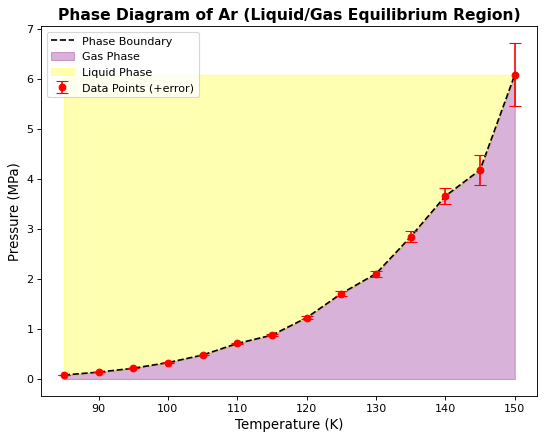

Execution Time: 0.063952 seconds


In [12]:
start_time = time.time() 

# Plot the results:
fig, ax = plt.subplots(figsize=(8, 6))

# Extract temperature, pressure, and error values:
temps = pressure_df["Temperature (K)"]
pressures = pressure_df["Computed Pressure (MPa)"]
errors = pressure_df["Error (Bootstrap) (MPa)"]  # Make sure this column exists

# Plot the phase boundary:
ax.plot(temps, pressures, linestyle='--', color='black', label='Phase Boundary')

# Scatter plot with error bars:
ax.errorbar(temps, pressures, yerr=errors, fmt='o', color='red', capsize=5, label='Data Points (+error)')

# Shade below the curve (liquid region):
ax.fill_between(temps, pressures, 0, color='purple', alpha=0.3, label='Gas Phase')

# Shade above the curve (gas region):
ax.fill_between(temps, pressures, pressures.max(), color='yellow', alpha=0.3, label='Liquid Phase')

# Labels and title:
ax.set_title('Phase Diagram of Ar (Liquid/Gas Equilibrium Region)', fontsize=14, fontweight='bold')
ax.set_xlabel('Temperature (K)', fontsize=12)
ax.set_ylabel('Pressure (MPa)', fontsize=12)
ax.legend()

plt.show()


end_time = time.time() 

elapsed_time = end_time - start_time 
print(f"Execution Time: {elapsed_time:.6f} seconds")

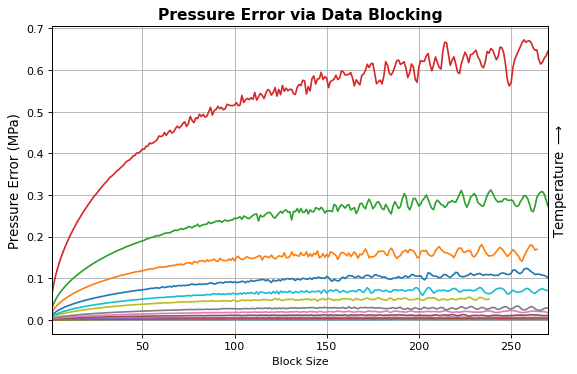

Execution Time: 0.065105 seconds


In [13]:
start_time = time.time() 

fig, ax1 = plt.subplots(figsize=(8, 5))

for (block_size, block_error, n) in zip(all_block_sizes, all_block_errors, n_density):
    
    ax1.plot(block_size, block_error * amd7.epsilon * (n / (3 * amd7.N)) / 1e6 , linestyle='-')

ax1.set_xlabel('Block Size')
ax1.set_ylabel('Pressure Error (MPa)', fontsize=12)
ax1.set_title('Pressure Error via Data Blocking', fontsize=14, fontweight='bold')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.set_ylabel('Temperature $\\longrightarrow$', fontsize=12)
ax2.set_yticks([])

plt.xlim(min(block_sizes), max(block_size))

plt.show()


end_time = time.time() 

elapsed_time = end_time - start_time 
print(f"Execution Time: {elapsed_time:.6f} seconds")

### **Calculation of the Specific Heat per Particle with  Error Propagation**

In molecular dynamics, the specific heat per particle at constant volume is estimated using the fluctuations in the kinetic energy
$$
c_V = \left( \frac{2}{3} - N \frac{\mathrm{Var}(K)}{\langle K \rangle^2} \right)^{-1} .
$$

We rewrite the fluctuation term using $X = \langle K \rangle$, $Y = \langle K^2 \rangle$, and $\mathrm{Var}(K) = Y - X^2$.  
Substituting these into the expression for $c_V$:
$$
c_V = \left( \frac{2}{3} - N  \frac{Y - X^2}{X^2} \right)^{-1}
= \left( \frac{2}{3} - N \left( \frac{Y}{X^2} - 1 \right) \right)^{-1}
= \left( \frac{2}{3} + N - N  \frac{Y}{X^2} \right)^{-1} .
$$

#### **Uncertainty Propagation**
Even though we typically have only one simulation run, the kinetic energy $K$ fluctuates over time. We compute $X = \langle K \rangle$ and $Y = \langle K^2 \rangle$ by averaging over this time series. Since these averages depend on the specific sampled time points, they themselves are **statistical estimators** — and therefore uncertain.

To quantify the uncertainty in $c_V$, we apply the multivariate error propagation formula assuming $X$ and $Y$ are random variables with uncertainties:
- $\sigma_X^2$ is the standard error squared of $X = \langle K \rangle$
- $\sigma_Y^2$ is the standard error squared of $Y = \langle K^2 \rangle$
- $\mathrm{Cov}(X, Y)$ is the covariance between $X$ and $Y$

These do not represent fluctuations in individual $K$ values, but rather the uncertainty in the mean values computed from a **finite sample**.  
Assuming we have $N_\text{eff}$ statistically independent samples (e.g. via data thinning or blocking), the standard errors are
$$
\sigma_X^2 = \frac{\mathrm{Var}(K)}{N_\text{eff}}, \quad
\sigma_Y^2 = \frac{\mathrm{Var}(K^2)}{N_\text{eff}}, \quad
\mathrm{Cov}(X, Y) = \frac{\mathrm{Cov}(K, K^2)}{N_\text{eff}} .
$$

This gives us the propagated uncertainty
$$
\sigma_{c_V}^2 =
\left( \frac{\partial c_V}{\partial X} \right)^2 \sigma_X^2 +
\left( \frac{\partial c_V}{\partial Y} \right)^2 \sigma_Y^2 +
2  \frac{\partial c_V}{\partial X}  \frac{\partial c_V}{\partial Y}  \mathrm{Cov}(X, Y) .
$$

#### **Partial Derivatives**
Let
$$
f(X, Y) = \left( \frac{2}{3} + N - N  \frac{Y}{X^2} \right)^{-1} ,
$$
and define the denominator as
$$
D = \frac{2}{3} + N - N  \frac{Y}{X^2} .
$$

Then the derivatives are
$$
\frac{\partial f}{\partial X} = \frac{2 N Y}{X^3 D^2}, \quad
\frac{\partial f}{\partial Y} = \frac{N}{X^2 D^2} .
$$

#### **Final Expression for Uncertainty**
Putting it all together:
$$
\sigma_{c_V} = \sqrt{\left( \frac{2 N Y}{X^3 D^2} \right)^2 \sigma_X^2 + \left( \frac{N}{X^2 D^2} \right)^2 \sigma_Y^2 + 2  \left( \frac{2 N Y}{X^3 D^2} \right)  \left( \frac{N}{X^2 D^2} \right)  \mathrm{Cov}(X, Y)} .
$$
This expression gives the total uncertainty on $c_V$, fully accounting for:
- Fluctuations in both $\langle K \rangle$ and $\langle K^2 \rangle$
- Finite sampling effects
- Their statistical correlation.

In [15]:
start_time = time.time() 
# Initialize a DataFrame to store results with error columns
columns = ["Temperature (K)","Kinetic Energy (J)", "Specific Heat per Particle (J/K)", "Specific Heat (J/mol·K)", "Error (J/mol·K)", "Correlation Time τ_CV"]

cv_df = pd.DataFrame(columns=columns)

# Initialize a list to store the block errors for each iteration
all_block_sizes = []
all_block_errors = []

# Loop over temperature and number density values
for i, (temp, n) in enumerate(zip(temps, n_density)):

    # ==========================
    # 1. Compute Kinetic Energy Statistics
    # ==========================
    ek_series = energies_eq[i, :, 0]
    avg_kin = np.mean(ek_series)
    avg_kin_J = np.mean(ek_series) * amd7.epsilon
    sq_avg_kin = np.mean(ek_series**2)
    var_kin = sq_avg_kin - avg_kin**2
    
    # ==========================
    # 2. Compute Specific Heat (c_V)
    # ==========================
    kin_fluct = var_kin / avg_kin**2
    cv = (2/3 - amd7.N * kin_fluct)**(-1)  # Specific heat per particle (dimensionless)

    # ==========================
    # 3. Estimate Error via Autocorrelation
    # ==========================
    tau_cv, _, thinned_cv = amd7.estimate_error(ek_series, max_lag=200)

    X, Y = avg_kin, sq_avg_kin
    D = (2/3 + amd7.N - amd7.N * Y / X**2)
    X_samples = thinned_cv
    Y_samples = thinned_cv**2

    sigma_X = np.var(X_samples) / len(X_samples)
    sigma_Y = np.var(Y_samples) / len(Y_samples)
    cov_XY = np.cov(X_samples, Y_samples)[0, 1] / len(X_samples)

    df_dX = (2 * amd7.N * Y) / (X**3 * D**2)
    df_dY = amd7.N / (X**2 * D**2)

    error_cv = np.sqrt((df_dX**2) * sigma_X + (df_dY**2) * sigma_Y + 2 * df_dX * df_dY * cov_XY)

    # ==========================
    # 4. Data Blocking
    # ==========================
    block_sizes, block_errors, block_averaged_data = amd7.data_blocking(ek_series, tau_cv)

    # Compute stats from block data
    X_blocks = block_averaged_data
    Y_blocks = block_averaged_data**2

    var_X_block = np.var(X_blocks) / len(X_blocks)
    var_Y_block = np.var(Y_blocks) / len(Y_blocks)
    cov_XY_block = np.cov(X_blocks, Y_blocks)[0, 1] / len(X_blocks)

    error_cv_blocking = np.sqrt((df_dX**2) * var_X_block + (df_dY**2) * var_Y_block + 2 * df_dX * df_dY * cov_XY_block)

    all_block_sizes.append(block_sizes)
    all_block_errors.append(block_errors)

    # ==========================
    # 5. Estimate Error via Bootstrap
    # ==========================
    bootstrap_samples = amd7.block_bootstrap(block_averaged_data, num_resamples=5000)

    bootstrap_cv = []
    for sample in bootstrap_samples:
        X = np.mean(sample)
        Y = np.mean(sample**2)
        kin_fluct = (Y - X**2) / X**2
        cv_sample = (2/3 - amd7.N * kin_fluct)**(-1)
        bootstrap_cv.append(cv_sample)

    bootstrap_cv = np.array(bootstrap_cv)

    # Final estimate and error
    cv_bootstrap = np.mean(bootstrap_cv)
    error_cv_bootstrap = np.std(bootstrap_cv, ddof=1)

    # ==========================
    # 6. Convert Units
    # ==========================
    cv_molar = cv_bootstrap * k_B * N_A
    error_cv_molar = error_cv_bootstrap * k_B * N_A

    # ==========================
    # 7. Store Results
    # ==========================
    cv_df.loc[i] = [temp, f"{avg_kin_J:.3e}", f"{cv_bootstrap:.3g}", f"{cv_molar:.3g}", f"{error_cv_molar:.3g}", f"{tau_cv:.3g}"]

cv_df

end_time = time.time() 

elapsed_time = end_time - start_time 
print(f"Execution Time: {elapsed_time:.6f} seconds")

Execution Time: 0.831780 seconds


In [16]:
cv_df

,Temperature (K),Kinetic Energy (J),Specific Heat per Particle (J/K),Specific Heat (J/mol·K),Error (J/mol·K),Correlation Time τ_CV
0,85.0,5.531e-20,1.53,12.7,0.0793,48.4
1,90.0,5.769e-20,1.52,12.6,0.0363,37
2,95.0,6.069e-20,1.52,12.6,0.0428,66.7
3,100.0,6.563e-20,1.53,12.7,0.0964,206
4,105.0,6.772e-20,1.55,12.9,0.0902,56.3
5,110.0,6.834e-20,1.54,12.8,0.049,30.2
6,115.0,7.134e-20,1.64,13.6,0.258,59.7
7,120.0,8.193e-20,1.6,13.3,0.244,62.5
8,125.0,8.135e-20,1.71,14.2,0.449,41.6
9,130.0,7.850e-20,1.74,14.4,0.371,40.6


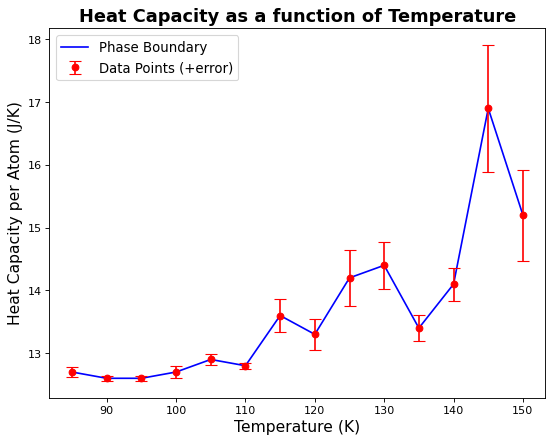

Execution Time: 0.065705 seconds


In [17]:
start_time = time.time() 
# Plot the results:
fig, ax = plt.subplots(figsize=(8, 6))

# Extract temperature, pressure, and error values:
temps = pd.to_numeric(cv_df["Temperature (K)"])
cv = pd.to_numeric(cv_df["Specific Heat (J/mol·K)"])
errors = pd.to_numeric(cv_df["Error (J/mol·K)"])

# Plot the phase boundary:
ax.plot(temps, cv, linestyle='-', color='blue', label='Phase Boundary')

# Scatter plot with error bars:
ax.errorbar(temps, cv, yerr=errors, fmt='o', color='red', capsize=5, label='Data Points (+error)')

# Labels and title:
ax.set_title('Heat Capacity as a function of Temperature', fontsize=16, fontweight='bold')
ax.set_xlabel('Temperature (K)', fontsize=14)
ax.set_ylabel('Heat Capacity per Atom (J/K)', fontsize=14)
ax.legend(fontsize=12)

plt.show()
plt.show()

end_time = time.time() 

elapsed_time = end_time - start_time 
print(f"Execution Time: {elapsed_time:.6f} seconds")

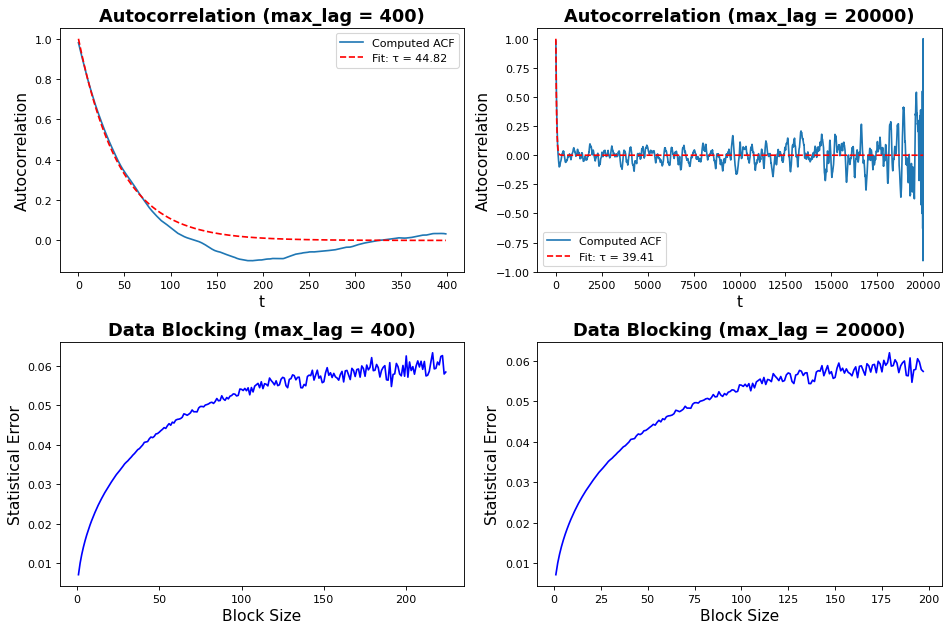

True Correlation Time: 50

=== Estimates for max_lag = 400 ===
Estimated τ: 44.82 ± 0.449 (Formula)
Estimated τ: 44.82 ± 0.059 (Data Blocking)
Number of independent samples (thinned): 445

=== Estimates for max_lag = 20000 ===
Estimated τ: 39.41 ± 0.397 (Formula)
Estimated τ: 39.41 ± 0.058 (Data Blocking)
Number of independent samples (thinned): 513
Execution Time: 1.347708 seconds


In [18]:
start_time = time.time() 

# Generate random correlated data
mean = 0  # Mean
std_dev = 1  # Standard deviation
tau_actual = 50  # True correlation time
num_data_pts = 20000  # Number of data points

data = amd6.normal_autocorr(mean, std_dev, tau_actual, num_data_pts)

# Define two different lag times
max_lag_1 = 400  
max_lag_2 = 20000  

# Compute autocorrelation functions
acf_values_1 = amd6.autocorr_func(data, max_lag_1)
acf_values_2 = amd6.autocorr_func(data, max_lag_2)

# Compute estimated correlation times
tau_estimated_1, error_1, thinned_data_1 = amd6.estimate_error(data, max_lag_1)
tau_estimated_2, error_2, thinned_data_2 = amd6.estimate_error(data, max_lag_2)

# Compute Data Blocking Error
block_sizes_1, block_errors_1, _ = amd6.data_blocking(data, tau_estimated_1)
block_sizes_2, block_errors_2, _ = amd6.data_blocking(data, tau_estimated_2)

# Take the average of the last 20% of block errors
tail_start_1 = int(len(block_errors_1) * 0.8)
tail_start_2 = int(len(block_errors_2) * 0.8)
avg_tail_block_error_1 = np.mean(block_errors_1[tail_start_1:])
avg_tail_block_error_2 = np.mean(block_errors_2[tail_start_2:])


def exp_decay(t, a, b, c):
    return a * np.exp(-b * t) + c

lags_1 = np.arange(max_lag_1)
lags_2 = np.arange(max_lag_2)

fit_values_1 = exp_decay(lags_1, 1.0, 1 / tau_estimated_1, 0.0)
fit_values_2 = exp_decay(lags_2, 1.0, 1 / tau_estimated_2, 0.0)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Autocorrelation function plots
axes[0, 0].plot(lags_1, acf_values_1, label="Computed ACF", linestyle="-", markersize=4)
axes[0, 0].plot(lags_1, fit_values_1, label=f"Fit: τ = {tau_estimated_1:.2f}", linestyle="--", color="red")
axes[0, 0].set_xlabel("t", fontsize=14)
axes[0, 0].set_ylabel("Autocorrelation", fontsize=14)
axes[0, 0].legend()
axes[0, 0].set_title(f"Autocorrelation (max_lag = {max_lag_1})", fontsize=16, fontweight='bold')

axes[0, 1].plot(lags_2, acf_values_2, label="Computed ACF", linestyle="-", markersize=4)
axes[0, 1].plot(lags_2, fit_values_2, label=f"Fit: τ = {tau_estimated_2:.2f}", linestyle="--", color="red")
axes[0, 1].set_xlabel("t", fontsize=14)
axes[0, 1].set_ylabel("Autocorrelation", fontsize=14)
axes[0, 1].legend()
axes[0, 1].set_title(f"Autocorrelation (max_lag = {max_lag_2})", fontsize=16, fontweight='bold')

# Data Blocking Error Plots
axes[1, 0].plot(block_sizes_1, block_errors_1, linestyle="-", color="blue")
axes[1, 0].set_xlabel("Block Size", fontsize=14)
axes[1, 0].set_ylabel("Statistical Error", fontsize=14)
axes[1, 0].set_title(f"Data Blocking (max_lag = {max_lag_1})", fontsize=16, fontweight='bold')

axes[1, 1].plot(block_sizes_2, block_errors_2, linestyle="-", color="blue")
axes[1, 1].set_xlabel("Block Size", fontsize=14)
axes[1, 1].set_ylabel("Statistical Error", fontsize=14)
axes[1, 1].set_title(f"Data Blocking (max_lag = {max_lag_2})", fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"True Correlation Time: {tau_actual}")
print(f"\n=== Estimates for max_lag = {max_lag_1} ===")
print(f"Estimated τ: {tau_estimated_1:.2f} ± {error_1:.3f} (Formula)")
print(f"Estimated τ: {tau_estimated_1:.2f} ± {avg_tail_block_error_1:.3f} (Data Blocking)")
print(f"Number of independent samples (thinned): {len(thinned_data_1)}")

print(f"\n=== Estimates for max_lag = {max_lag_2} ===")
print(f"Estimated τ: {tau_estimated_2:.2f} ± {error_2:.3f} (Formula)")
print(f"Estimated τ: {tau_estimated_2:.2f} ± {avg_tail_block_error_2:.3f} (Data Blocking)")
print(f"Number of independent samples (thinned): {len(thinned_data_2)}")


end_time = time.time() 

elapsed_time = end_time - start_time 
print(f"Execution Time: {elapsed_time:.6f} seconds")